In [152]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [154]:
# Imports
import pandas as pd
import numpy as np
import sys

from datetime import datetime as dt

# Scikit-learn
from sklearn.model_selection import *
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN

import missingno as msno
import prince

import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [146]:
def fit_model(x_train, y_train, estimator, cv):
  avg_fit_time = []
  sd_fit_time = []
  max_fit_time = []

  avg_train_score = []
  sd_train_score = []
  max_train_score = []
  min_train_score = []

  avg_test_score = []
  sd_test_score = []
  max_test_score = []
  min_test_score = []
  
  estimator_cv = []

  for est in estimator:
    print('\nCurrent:', est)
    score = cross_validate(est, x_train, y_train, scoring = 'f1', cv = cv, return_train_score=True, return_estimator = True,
                           n_jobs = -1, verbose = 1)
    
    avg_fit_time.append(np.mean(score['fit_time']))
    sd_fit_time.append(np.std(score['fit_time']))
    max_fit_time.append(np.max(score['fit_time']))

    avg_train_score.append(np.mean(score['train_score']))
    sd_train_score.append(np.std(score['train_score']))
    max_train_score.append(np.max(score['train_score']))
    min_train_score.append(np.min(score['train_score']))

    avg_test_score.append(np.mean(score['test_score']))
    sd_test_score.append(np.std(score['test_score']))
    max_test_score.append(np.max(score['test_score']))
    min_test_score.append(np.min(score['test_score']))

    param = []
    for i in score['estimator']:
      param.append(i.get_params())
    
    estimator_cv.append(param)

  result = pd.DataFrame({
    'model' : estimator,
    'avg_fit_time' : avg_fit_time,
    'sd_fit_time' : sd_fit_time,
    'max_fit_time' : max_fit_time,

    'avg_train_score' : avg_train_score,
    'sd_train_score' : sd_train_score,
    'max_train_score' : max_train_score,
    'min_train_score' : min_train_score,

    'avg_test_score' : avg_test_score,
    'sd_test_score' : sd_test_score,
    'max_test_score' : max_test_score,
    'min_test_score' : min_test_score,

    'estimators' : estimator_cv,
  })

  return(result)

In [139]:
ye = pd.read_csv('train.csv')
ye['DC201'].value_counts()

Layak Minum          32398
Tidak Layak Minum     3572
Name: DC201, dtype: int64

In [43]:
df = pd.read_csv('train.csv')
df['DC201'] = [1 if i == 'Layak Minum' else 0 for i in df['DC201']]

df_test = pd.read_csv('test.csv')
df.head()

,id,DC024,DC025,DC205,DC206,DC207,DC208,DC209,DC210,DC211,...,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC109,DC142a,DC201
0,1,11,2,16.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,1,12.0,60.0,1
1,2,11,2,31.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,1.0,1.0,2,31.0,70.0,1
2,3,11,2,12.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,4,11.0,75.0,1
3,6,11,2,12.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,NaN,1.0,0.0,1.0,1,11.0,85.0,1
4,7,11,2,12.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,2,11.0,65.0,1


# Overall: Correlation

Seems that DC109 has very high correlation with DC205. We can drop either one OR use PCA to reduce dimensions.

In [44]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,id,DC024,DC025,DC205,DC206,DC207,DC208,DC209,DC210,DC211,DC212,DC213,DC214,DC215,DC216,DC217,DC219,DC220,DC226,DC230a,DC230b,DC232,DC232b,DC235,DC237,DC237a,DC237b,DC237c,DC237d,DC237e,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC109,DC142a,DC201
id,1.000000,0.974972,0.101476,0.039126,-0.073837,-0.053239,-0.149891,-0.113275,-0.072947,-0.142769,-0.054095,-0.150405,-0.016839,-0.122800,0.039935,0.012023,-0.006929,-0.026369,0.031266,0.086452,-0.037726,-0.014600,0.035597,0.267302,0.031720,0.020389,0.009859,0.132599,-0.008310,-0.005245,0.111251,0.101751,-0.154744,0.148014,0.089435,0.038593,-0.151877,0.067607,-0.003896,-0.011420
DC024,0.974972,1.000000,0.115967,0.050238,-0.073412,-0.073789,-0.158540,-0.109523,-0.110910,-0.153732,-0.053324,-0.151308,-0.009990,-0.159182,0.029100,0.015285,-0.009633,-0.038624,0.026520,0.102953,-0.040812,-0.018593,0.039849,0.268678,0.028227,0.021443,0.010874,0.122498,-0.006412,-0.004637,0.095104,0.095020,-0.158949,0.162899,0.086701,0.036136,-0.171151,0.075237,-0.009484,-0.024560
DC025,0.101476,0.115967,1.000000,0.249896,-0.154560,-0.128228,-0.228847,-0.324782,-0.124580,-0.151809,-0.174184,-0.167822,-0.063258,-0.149274,-0.026840,-0.052370,-0.016371,0.054666,0.003595,0.138995,-0.085915,-0.111371,0.021138,0.262525,0.244903,0.233396,0.000237,0.113192,0.004654,-0.002844,0.130321,0.122635,-0.014153,0.433814,0.340383,0.042213,-0.074408,0.268028,-0.072236,-0.256544
DC205,0.039126,0.050238,0.249896,1.000000,-0.222417,-0.093648,-0.286602,-0.333856,-0.140023,-0.218461,-0.163972,-0.216568,-0.067192,-0.168920,-0.188297,-0.076392,0.016731,-0.013647,0.058311,0.230626,-0.106181,-0.158554,0.021744,0.217918,0.107267,0.101865,0.011114,0.026510,-0.004451,-0.002786,0.044352,0.104596,-0.063276,0.092780,0.092391,0.012745,-0.411133,0.879477,-0.127207,-0.270813
DC206,-0.073837,-0.073412,-0.154560,-0.222417,1.000000,0.060063,0.351162,0.211296,0.091119,0.205554,0.074703,0.192204,0.094601,0.196780,0.087942,0.064457,-0.019932,0.012345,-0.062729,-0.114374,0.084267,0.085329,-0.020945,-0.144873,-0.063726,-0.062952,0.006800,-0.116366,-0.001758,0.002638,-0.018481,-0.133000,0.043190,-0.101630,-0.069840,0.002898,0.220474,-0.268618,0.066888,0.161778
DC207,-0.053239,-0.073789,-0.128228,-0.093648,0.060063,1.000000,0.111847,0.140003,0.150605,0.100905,0.116634,0.055133,0.033448,0.082059,0.113544,0.063278,-0.039788,0.071556,-0.038021,-0.063155,0.050117,0.058979,-0.015097,-0.092354,-0.011286,-0.010756,0.004610,-0.020886,0.008609,0.000681,-0.002967,-0.035623,0.041371,-0.046177,-0.016435,-0.007356,0.212426,-0.099104,0.074492,0.062056
DC208,-0.149891,-0.158540,-0.228847,-0.286602,0.351162,0.111847,1.000000,0.419783,0.210997,0.383709,0.154426,0.211133,0.115066,0.229913,0.194178,0.158217,-0.118513,-0.021009,-0.173051,-0.175274,0.135411,0.169757,-0.029164,-0.235131,-0.092394,-0.087767,0.006418,-0.128488,-0.004757,0.002426,-0.036687,-0.188010,0.062378,-0.130919,-0.087465,0.001851,0.433327,-0.332802,0.136023,0.191942
DC209,-0.113275,-0.109523,-0.324782,-0.333856,0.211296,0.140003,0.419783,1.000000,0.218659,0.376977,0.299144,0.184668,0.111476,0.151600,0.252686,0.167629,-0.078651,-0.008899,-0.204371,-0.204602,0.114647,0.165458,-0.036233,-0.264673,-0.160128,-0.154663,0.002417,-0.111207,0.008820,-0.001274,-0.081163,-0.200057,0.067572,-0.142009,-0.152640,-0.016002,0.627516,-0.357379,0.187238,0.214982
DC210,-0.072947,-0.110910,-0.124580,-0.140023,0.091119,0.150605,0.210997,0.218659,1.000000,0.210844,0.174563,0.069825,0.043368,0.128184,0.156324,0.094380,-0.107253,-0.016060,-0.102546,-0.092698,0.053642,0.074374,-0.024120,-0.154965,-0.044076,-0.045888,0.013873,-0.042295,0.015014,0.007654,-0.017132,-0.081629,0.035417,-0.052197,-0.008909,-0.004622,0.340843,-0.143018,0.106805,0.108526
DC211,-0.142769,-0.153732,-0.151809,-0.218461,0.205554,0.100905,0.383709,0.376977,0.210844,1.000000,0.171143,0.147264,0.097489,0.154854,0.173356,0.216898,-0.224859,-0.167270,-0.119596,-0.148645,0.099166,0.131112,-0.034787,-0.186511,-0.117533,-0.115541,0.008442,-0.097949,0.012364,0.007

# Overall: Missing Values

Seems like DC232, DC232b, DC230b has similar number of missing values.

From the metadata, they all have similar description. These are not missing randomly.

Perhaps we can use simple imputer?

In [45]:
missing_values_table(df)

Your selected dataframe has 40 columns.
There are 33 columns that have missing values.


,Missing Values,% of Total Values
DC235,10446,29.0
DC242,5374,14.9
DC232,3024,8.4
DC232b,3024,8.4
DC230b,3009,8.4
DC241,612,1.7
DC213,77,0.2
DC142a,52,0.1
DC207,44,0.1
DC210,41,0.1


<Axes: >

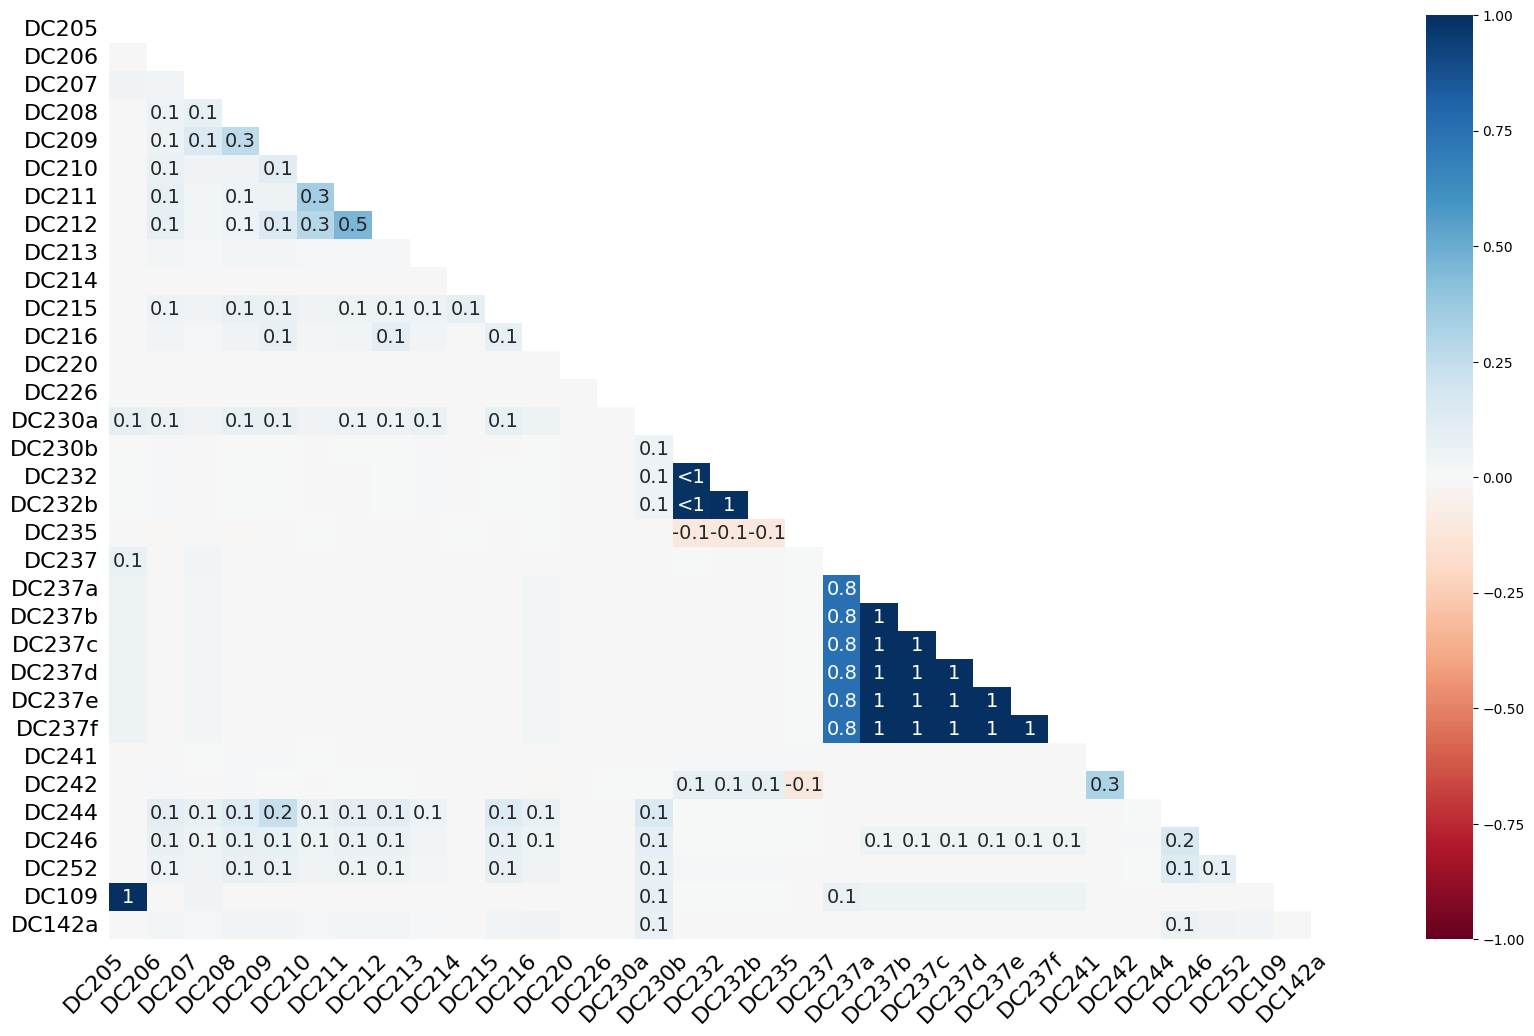

In [46]:
msno.heatmap(df)

# DC235

Dc235 has the most missing values, perhaps it is not a coincidence?

In [47]:
df['DC235'].value_counts()

3.0    8811
1.0    8479
2.0    8237
Name: DC235, dtype: int64

#### Analyze correlation with label

No significant difference

In [48]:
df2 = df[df.isnull().any(axis = 1)]

print('All\n', df[['DC235', 'DC201']].corr())
print('\nMissing Only\n', df2[['DC235', 'DC201']].corr())

All
           DC235     DC201
DC235  1.000000 -0.208762
DC201 -0.208762  1.000000

Missing Only
           DC235     DC201
DC235  1.000000 -0.201397
DC201 -0.201397  1.000000


# Split X y

In [49]:
X = df.drop(['id','DC109', 'DC201'], axis = 1)
y = df['DC201']
X_test = df_test.drop(['DC109', 'id'], axis = 1)
X_test_id = df_test['id']

# Impute All Missing Values by Iterative Imputer

In [50]:
imputer = IterativeImputer(random_state=1333)
#imputer.set_output(transform = 'pandas')
X_pre = imputer.fit_transform(X)
X_test_pre = imputer.transform(X_test)
X_pre.head()

,DC024,DC025,DC205,DC206,DC207,DC208,DC209,DC210,DC211,DC212,...,DC237d,DC237e,DC237f,DC241,DC242,DC244,DC246,DC252,DC270a,DC142a
0,11.0,2.0,16.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,2.0,1.0,60.0
1,11.0,2.0,31.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,1.0,2.0,70.0
2,11.0,2.0,12.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.000000,1.0,1.0,0.0,4.0,75.0
3,11.0,2.0,12.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,0.957634,1.0,0.0,1.0,1.0,85.0
4,11.0,2.0,12.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.000000,0.0,1.0,0.0,2.0,65.0


In [51]:
X_pre = X_pre.clip(lower = 0)

# Dimensionality Reduction

In [55]:
mca = prince.MCA(
    n_components=16,
    n_iter=3,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=323
)

X_pre2 = mca.fit_transform(X_pre)
X_test_pre2 = mca.transform(X_test_pre)

In [56]:
X_pre2.to_csv('X_pre2.csv', index = False)
X_test_pre2.to_csv('X_test_pre2.csv', index = False)

# Tune

In [57]:
from scipy.stats import randint, uniform

# define the parameter distributions to search over
param_distribution = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': randint(10, 1000),
    'max_depth': [-1, 5, 10, 15, 20, 25],
    'learning_rate': uniform(0.01, 0.5),
    'n_estimators': randint(50, 1000),
    'min_child_samples': randint(1, 200),
    'reg_alpha': uniform(0, 10),
    'reg_lambda': uniform(0, 10),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.5, 0.5),
    'subsample_freq': randint(1, 10),
    'min_split_gain': uniform(0, 1),
    'min_child_weight': uniform(0.01, 10),
    'scale_pos_weight': uniform(0.5, 1.5),
}

# create an instance of the LGBMClassifier estimator
estimator = LGBMClassifier(random_state=424)

# create an instance of RandomizedSearchCV
random_search2 = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distribution,
    n_iter=250,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

res_lgbm2 = random_search2.fit(X_pre2, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8982714934301164, learning_rate=0.10171739493308189, max_depth=20, min_child_samples=21, min_child_weight=1.5701864044243652, min_split_gain=0.15599452033620265, n_estimators=380, num_leaves=468, reg_alpha=8.661761457749352, reg_lambda=6.011150117432088, scale_pos_weight=1.5621088666940683, subsample=0.5102922471479012, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8982714934301164, learning_rate=0.10171739493308189, max_depth=20, min_child_samples=21, min_child_weight=1.5701864044243652, min_split_gain=0.15599452033620265, n_estimators=380, num_leaves=468, reg_alpha=8.661761457749352, reg_lambda=6.011150117432088, scale_pos_weight=1.5621088666940683, subsample=0.5102922471479012, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8982714934301164, learning_rate=0.10171739493308189, max_depth=20, min_child_samples=21, min_child_weight=1.5701864044243652, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9916154429033941, learning_rate=0.24338144662398997, max_depth=20, min_child_samples=51, min_child_weight=6.813075385877797, min_split_gain=0.450499251969543, n_estimators=323, num_leaves=397, reg_alpha=9.422017556848527, reg_lambda=5.632882178455393, scale_pos_weight=1.0781247538098742, subsample=0.5079831261101071, subsample_freq=2; total time=   0.4s
[CV] END boosting_type=goss, colsample_bytree=0.9916154429033941, learning_rate=0.24338144662398997, max_depth=20, min_child_samples=51, min_child_weight=6.813075385877797, min_split_gain=0.450499251969543, n_estimators=323, num_leaves=397, reg_alpha=9.422017556848527, reg_lambda=5.632882178455393, scale_pos_weight=1.0781247538098742, subsample=0.5079831261101071, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9916154429033941, learning_rate=0.24338144662398997, max_depth=20, min_child_samples=51, min_child_weight=6.813075385877797, min_split_gain=0.45

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8416317594127292, learning_rate=0.31499832889131046, max_depth=10, min_child_samples=81, min_child_weight=2.597799816000169, min_split_gain=0.662522284353982, n_estimators=51, num_leaves=399, reg_alpha=2.079416628681888, reg_lambda=5.677003278199915, scale_pos_weight=0.5469699386833379, subsample=0.9211423872974993, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8416317594127292, learning_rate=0.31499832889131046, max_depth=10, min_child_samples=81, min_child_weight=2.597799816000169, min_split_gain=0.662522284353982, n_estimators=51, num_leaves=399, reg_alpha=2.079416628681888, reg_lambda=5.677003278199915, scale_pos_weight=0.5469699386833379, subsample=0.9211423872974993, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.9010984903770198, learning_rate=0.04727532183988541, max_depth=-1, min_child_samples=88, min_child_weight=3.958815181755697, min_split_gain=0.2934

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5871832145024958, learning_rate=0.355468869051233, max_depth=5, min_child_samples=104, min_child_weight=1.3852094414599325, min_split_gain=0.3410663510502585, n_estimators=522, num_leaves=955, reg_alpha=9.246936182785628, reg_lambda=8.77339353380981, scale_pos_weight=0.8869124415727334, subsample=0.8299920230170895, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.5579345297625649, learning_rate=0.44155171293779677, max_depth=15, min_child_samples=162, min_child_weight=0.9641011649041131, min_split_gain=0.37081825219826636, n_estimators=623, num_leaves=737, reg_alpha=6.659223566174966, reg_lambda=5.912977877077271, scale_pos_weight=0.9120826894850962, subsample=0.7806217129238506, subsample_freq=3; total time=  58.6s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5871832145024958, learning_rate=0.355468869051233, max_depth=5, min_child_samples=104, min_child_weight=1.3852094414599325, min_split_gain=0.3410663510502585, n_estimators=522, num_leaves=955, reg_alpha=9.246936182785628, reg_lambda=8.77339353380981, scale_pos_weight=0.8869124415727334, subsample=0.8299920230170895, subsample_freq=9; total time=   0.2s[CV] END boosting_type=goss, colsample_bytree=0.5871832145024958, learning_rate=0.355468869051233, max_depth=5, min_child_samples=104, min_child_weight=1.3852094414599325, min_split_gain=0.3410663510502585, n_estimators=522, num_leaves=955, reg_alpha=9.246936182785628, reg_lambda=8.77339353380981, scale_pos_weight=0.8869124415727334, subsample=0.8299920230170895, subsample_freq=9; total time=   0.2s



[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5871832145024958, learning_rate=0.355468869051233, max_depth=5, min_child_samples=104, min_child_weight=1.3852094414599325, min_split_gain=0.3410663510502585, n_estimators=522, num_leaves=955, reg_alpha=9.246936182785628, reg_lambda=8.77339353380981, scale_pos_weight=0.8869124415727334, subsample=0.8299920230170895, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5871832145024958, learning_rate=0.355468869051233, max_depth=5, min_child_samples=104, min_child_weight=1.3852094414599325, min_split_gain=0.3410663510502585, n_estimators=522, num_leaves=955, reg_alpha=9.246936182785628, reg_lambda=8.77339353380981, scale_pos_weight=0.8869124415727334, subsample=0.8299920230170895, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.6209261454502258, learning_rate=0.05655138390294961, max_depth=15, min_child_samples=197, min_child_weight=9.014180571633304, min_split_gain=0.633

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8842770071531545, learning_rate=0.03180188587721688, max_depth=15, min_child_samples=158, min_child_weight=9.549285770025874, min_split_gain=0.9148643902204485, n_estimators=148, num_leaves=901, reg_alpha=0.15456616528867428, reg_lambda=9.283185625877254, scale_pos_weight=1.1422762224759715, subsample=0.9833274095218347, subsample_freq=3; total time=   0.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8842770071531545, learning_rate=0.03180188587721688, max_depth=15, min_child_samples=158, min_child_weight=9.549285770025874, min_split_gain=0.9148643902204485, n_estimators=148, num_leaves=901, reg_alpha=0.15456616528867428, reg_lambda=9.283185625877254, scale_pos_weight=1.1422762224759715, subsample=0.9833274095218347, subsample_freq=3; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8842770071531545, learning_rate=0.03180188587721688, max_depth=15, min_child_samples=158, min_child_weight=9.549285770025874, min_split_gain=0.9148643902204485, n_estimators=148, num_leaves=901, reg_alpha=0.15456616528867428, reg_lambda=9.283185625877254, scale_pos_weight=1.1422762224759715, subsample=0.9833274095218347, subsample_freq=3; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8842770071531545, learning_rate=0.03180188587721688, max_depth=15, min_child_samples=158, min_child_weight=9.549285770025874, min_split_gain=0.9148643902204485, n_estimators=148, num_leaves=901, reg_alpha=0.15456616528867428, reg_lambda=9.283185625877254, scale_pos_weight=1.1422762224759715, subsample=0.9833274095218347, subsample_freq=3; total time=   0.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8842770071531545, learning_rate=0.03180188587721688, max_depth=15, min_child_samples=158, min_child_weight=9.549285770025874, min_split_gain=0.9148643902204485, n_estimators=148, num_leaves=901, reg_alpha=0.15456616528867428, reg_lambda=9.283185625877254, scale_pos_weight=1.1422762224759715, subsample=0.9833274095218347, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.6326011838408627, learning_rate=0.1319948216895418, max_depth=25, min_child_samples=109, min_child_weight=4.877421529594551, min_split_gain=0.906098787718554, n_estimators=76, num_leaves=235, reg_alpha=3.500784076946757, reg_lambda=6.451033620305648, scale_pos_weight=1.5033860894946494, subsample=0.9320837825359516, subsample_freq=3; total time=   2.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.5376731280030641, learning_rate=0.16284850964359093, max_depth=-1, min_child_samples=67, min_child_weight=1.704927466860925, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.570042007618262, learning_rate=0.2691648261818684, max_depth=5, min_child_samples=17, min_child_weight=8.496697949246744, min_split_gain=0.13662133144202881, n_estimators=295, num_leaves=185, reg_alpha=5.528199769079078, reg_lambda=2.965101436477985, scale_pos_weight=1.1296712846694148, subsample=0.628103471797229, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.570042007618262, learning_rate=0.2691648261818684, max_depth=5, min_child_samples=17, min_child_weight=8.496697949246744, min_split_gain=0.13662133144202881, n_estimators=295, num_leaves=185, reg_alpha=5.528199769079078, reg_lambda=2.965101436477985, scale_pos_weight=1.1296712846694148, subsample=0.628103471797229, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.570042007618262, learning_rate=0.2691648261818684, max_depth=5, min_child_samples=17, min_child_weight=8.496697949246744, min_split_gain=0.13662133144202881, n_estimators=295, num_leaves=185, reg_alpha=5.528199769079078, reg_lambda=2.965101436477985, scale_pos_weight=1.1296712846694148, subsample=0.628103471797229, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.570042007618262, learning_rate=0.2691648261818684, max_depth=5, min_child_samples=17, min_child_weight=8.496697949246744, min_split_gain=0.13662133144202881, n_estimators=295, num_leaves=185, reg_alpha=5.528199769079078, reg_lambda=2.965101436477985, scale_pos_weight=1.1296712846694148, subsample=0.628103471797229, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.570042007618262, learning_rate=0.2691648261818684, max_depth=5, min_child_samples=17, min_child_weight=8.496697949246744, min_split_gain=0.13662133144202881, n_estimators=295, num_leaves=185, reg_alpha=5.528199769079078, reg_lambda=2.965101436477985, scale_pos_weight=1.1296712846694148, subsample=0.628103471797229, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.5376731280030641, learning_rate=0.16284850964359093, max_depth=-1, min_child_samples=67, min_child_weight=1.704927466860925, min_split_gain=0.5568012624583502, n_estimators=784, num_leaves=575, reg_alpha=6.96029796674973, reg_lambda=5.700611700893649, scale_pos_weight=0.6457647406561529, subsample=0.8075036133495849, subsample_freq=6; total time=   3.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.5407970902001202, learning_rate=0.012592431386993388, max_depth=15, min_child_samples=173, min_child_weight=1.9527395351204224, min_split_gain=0.0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.517971136898371, learning_rate=0.2427990090662301, max_depth=25, min_child_samples=125, min_child_weight=8.399335020693632, min_split_gain=0.8604046183116753, n_estimators=354, num_leaves=701, reg_alpha=0.388347344294232, reg_lambda=3.0326551467322282, scale_pos_weight=1.305623640794983, subsample=0.6633256208980205, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.517971136898371, learning_rate=0.2427990090662301, max_depth=25, min_child_samples=125, min_child_weight=8.399335020693632, min_split_gain=0.8604046183116753, n_estimators=354, num_leaves=701, reg_alpha=0.388347344294232, reg_lambda=3.0326551467322282, scale_pos_weight=1.305623640794983, subsample=0.6633256208980205, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.517971136898371, learning_rate=0.2427990090662301, max_depth=25, min_child_samples=125, min_child_weight=8.399335020693632, min_split_gain=0.8604046183116753, n_estimators=354, num_leaves=701, reg_alpha=0.388347344294232, reg_lambda=3.0326551467322282, scale_pos_weight=1.305623640794983, subsample=0.6633256208980205, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.517971136898371, learning_rate=0.2427990090662301, max_depth=25, min_child_samples=125, min_child_weight=8.399335020693632, min_split_gain=0.8604046183116753, n_estimators=354, num_leaves=701, reg_alpha=0.388347344294232, reg_lambda=3.0326551467322282, scale_pos_weight=1.305623640794983, subsample=0.6633256208980205, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.517971136898371, learning_rate=0.2427990090662301, max_depth=25, min_child_samples=125, min_child_weight=8.399335020693632, min_split_gain=0.8604046183116753, n_estimators=354, num_leaves=701, reg_alpha=0.388347344294232, reg_lambda=3.0326551467322282, scale_pos_weight=1.305623640794983, subsample=0.6633256208980205, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.635771457909871, learning_rate=0.4926259151953849, max_depth=15, min_child_samples=6, min_child_weight=0.526817211686077, min_split_gain=0.531354631568148, n_estimators=96, num_leaves=876, reg_alpha=6.374299014982066, reg_lambda=7.260913337226615, scale_pos_weight=1.963778119193802, subsample=0.7581501741505976, subsample_freq=3; total time=   1.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.5407970902001202, learning_rate=0.012592431386993388, max_depth=15, min_child_samples=173, min_child_weight=1.9527395351204224, min_split_gain=0.0709

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5240294620985169, learning_rate=0.484572865795693, max_depth=15, min_child_samples=34, min_child_weight=2.6189362334171395, min_split_gain=0.01530454029038475, n_estimators=708, num_leaves=451, reg_alpha=5.010398839152592, reg_lambda=5.393774484000625, scale_pos_weight=1.5259456540972116, subsample=0.8079255821949569, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5240294620985169, learning_rate=0.484572865795693, max_depth=15, min_child_samples=34, min_child_weight=2.6189362334171395, min_split_gain=0.01530454029038475, n_estimators=708, num_leaves=451, reg_alpha=5.010398839152592, reg_lambda=5.393774484000625, scale_pos_weight=1.5259456540972116, subsample=0.8079255821949569, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5240294620985169, learning_rate=0.484572865795693, max_depth=15, min_child_samples=34, min_child_weight=2.6189362334171395, min_split_gain=0.01530454029038475, n_estimators=708, num_leaves=451, reg_alpha=5.010398839152592, reg_lambda=5.393774484000625, scale_pos_weight=1.5259456540972116, subsample=0.8079255821949569, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5240294620985169, learning_rate=0.484572865795693, max_depth=15, min_child_samples=34, min_child_weight=2.6189362334171395, min_split_gain=0.01530454029038475, n_estimators=708, num_leaves=451, reg_alpha=5.010398839152592, reg_lambda=5.393774484000625, scale_pos_weight=1.5259456540972116, subsample=0.8079255821949569, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5240294620985169, learning_rate=0.484572865795693, max_depth=15, min_child_samples=34, min_child_weight=2.6189362334171395, min_split_gain=0.01530454029038475, n_estimators=708, num_leaves=451, reg_alpha=5.010398839152592, reg_lambda=5.393774484000625, scale_pos_weight=1.5259456540972116, subsample=0.8079255821949569, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.5600823239028211, learning_rate=0.1809398333582008, max_depth=15, min_child_samples=69, min_child_weight=0.9515698826856012, min_split_gain=0.3114133093912942, n_estimators=502, num_leaves=213, reg_alpha=0.17161101831750236, reg_lambda=7.63364423003911, scale_pos_weight=1.7103694655761692, subsample=0.6731521605447004, subsample_freq=5; total time=   6.3s
[CV] END boosting_type=dart, colsample_bytree=0.7242120714931237, learning_rate=0.5072287313054104, max_depth=15, min_child_samples=161, min_child_weight=0.19075363615520868, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6409273873867, learning_rate=0.06908241381082812, max_depth=20, min_child_samples=114, min_child_weight=6.2994284677988395, min_split_gain=0.877472013527053, n_estimators=469, num_leaves=738, reg_alpha=8.034809303848485, reg_lambda=2.820345725713065, scale_pos_weight=0.7661593156695843, subsample=0.8753073758204292, subsample_freq=3; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6409273873867, learning_rate=0.06908241381082812, max_depth=20, min_child_samples=114, min_child_weight=6.2994284677988395, min_split_gain=0.877472013527053, n_estimators=469, num_leaves=738, reg_alpha=8.034809303848485, reg_lambda=2.820345725713065, scale_pos_weight=0.7661593156695843, subsample=0.8753073758204292, subsample_freq=3; total time=   0.5s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6409273873867, learning_rate=0.06908241381082812, max_depth=20, min_child_samples=114, min_child_weight=6.2994284677988395, min_split_gain=0.877472013527053, n_estimators=469, num_leaves=738, reg_alpha=8.034809303848485, reg_lambda=2.820345725713065, scale_pos_weight=0.7661593156695843, subsample=0.8753073758204292, subsample_freq=3; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6409273873867, learning_rate=0.06908241381082812, max_depth=20, min_child_samples=114, min_child_weight=6.2994284677988395, min_split_gain=0.877472013527053, n_estimators=469, num_leaves=738, reg_alpha=8.034809303848485, reg_lambda=2.820345725713065, scale_pos_weight=0.7661593156695843, subsample=0.8753073758204292, subsample_freq=3; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6409273873867, learning_rate=0.06908241381082812, max_depth=20, min_child_samples=114, min_child_weight=6.2994284677988395, min_split_gain=0.877472013527053, n_estimators=469, num_leaves=738, reg_alpha=8.034809303848485, reg_lambda=2.820345725713065, scale_pos_weight=0.7661593156695843, subsample=0.8753073758204292, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.8658238776498202, learning_rate=0.07384486471123279, max_depth=-1, min_child_samples=96, min_child_weight=3.4180354025301782, min_split_gain=0.9307573256035647, n_estimators=86, num_leaves=789, reg_alpha=4.289940273750183, reg_lambda=7.508710677914974, scale_pos_weight=1.6318143111270236, subsample=0.5515619344179663, subsample_freq=1; total time=   1.0s
[CV] END boosting_type=gbdt, colsample_bytree=0.8658238776498202, learning_rate=0.07384486471123279, max_depth=-1, min_child_samples=96, min_child_weight=3.4180354025301782, min_split_gain=0.9

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7465128288859024, learning_rate=0.051642205597629824, max_depth=20, min_child_samples=99, min_child_weight=6.0344092590111895, min_split_gain=0.5537030523458008, n_estimators=518, num_leaves=493, reg_alpha=9.461945428816902, reg_lambda=7.812960504712025, scale_pos_weight=0.6701969030261721, subsample=0.9654645528436463, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.7526261862239285, learning_rate=0.4232287330538708, max_depth=25, min_child_samples=141, min_child_weight=8.965232284962005, min_split_gain=0.3892016787341631, n_estimators=445, num_leaves=454, reg_alpha=9.053819764192637, reg_lambda=0.9128667678613356, scale_pos_weight=0.9789704563856223, subsample=0.9750309835254025, subsample_freq=4; total time=   1.4s
[CV] END boosting_type=goss, colsample_bytree=0.7465128288859024, learning_rate=0.051642205597629824, max_depth=20, min_child_samples=99, min_child_weight=6.0344092590111895, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7465128288859024, learning_rate=0.051642205597629824, max_depth=20, min_child_samples=99, min_child_weight=6.0344092590111895, min_split_gain=0.5537030523458008, n_estimators=518, num_leaves=493, reg_alpha=9.461945428816902, reg_lambda=7.812960504712025, scale_pos_weight=0.6701969030261721, subsample=0.9654645528436463, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.7465128288859024, learning_rate=0.051642205597629824, max_depth=20, min_child_samples=99, min_child_weight=6.0344092590111895, min_split_gain=0.5537030523458008, n_estimators=518, num_leaves=493, reg_alpha=9.461945428816902, reg_lambda=7.812960504712025, scale_pos_weight=0.6701969030261721, subsample=0.9654645528436463, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7465128288859024, learning_rate=0.051642205597629824, max_depth=20, min_child_samples=99, min_child_weight=6.0344092590111895, min_split_gain=0.5537030523458008, n_estimators=518, num_leaves=493, reg_alpha=9.461945428816902, reg_lambda=7.812960504712025, scale_pos_weight=0.6701969030261721, subsample=0.9654645528436463, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.5469366450406459, learning_rate=0.10143299855365366, max_depth=20, min_child_samples=117, min_child_weight=6.392705938433504, min_split_gain=0.5166962574265667, n_estimators=753, num_leaves=456, reg_alpha=4.3567289867789105, reg_lambda=7.3003931656181855, scale_pos_weight=0.5715741915374732, subsample=0.7830186052470381, subsample_freq=3; total time= 1.6min
[CV] END boosting_type=dart, colsample_bytree=0.5469366450406459, learning_rate=0.10143299855365366, max_depth=20, min_child_samples=117, min_child_weight=6.392705938433504, min_split_g

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8490808570098726, learning_rate=0.2780481831720602, max_depth=-1, min_child_samples=157, min_child_weight=1.341851252237497, min_split_gain=0.07620037959916315, n_estimators=439, num_leaves=603, reg_alpha=4.166390577384792, reg_lambda=5.811626211808263, scale_pos_weight=1.8787648277533393, subsample=0.5413742100176531, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.8540905977915999, learning_rate=0.2508334939820577, max_depth=15, min_child_samples=182, min_child_weight=7.060843642966598, min_split_gain=0.24872415443028795, n_estimators=580, num_leaves=48, reg_alpha=4.344518444882714, reg_lambda=2.5368217387313874, scale_pos_weight=1.1078031301721256, subsample=0.7857365126025053, subsample_freq=4; total time= 1.2min


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8490808570098726, learning_rate=0.2780481831720602, max_depth=-1, min_child_samples=157, min_child_weight=1.341851252237497, min_split_gain=0.07620037959916315, n_estimators=439, num_leaves=603, reg_alpha=4.166390577384792, reg_lambda=5.811626211808263, scale_pos_weight=1.8787648277533393, subsample=0.5413742100176531, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8490808570098726, learning_rate=0.2780481831720602, max_depth=-1, min_child_samples=157, min_child_weight=1.341851252237497, min_split_gain=0.07620037959916315, n_estimators=439, num_leaves=603, reg_alpha=4.166390577384792, reg_lambda=5.811626211808263, scale_pos_weight=1.8787648277533393, subsample=0.5413742100176531, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.6033421799383727, learning_rate=0.1469805636605669, max_depth=15, min_child_samples=95, min_child_weight=3.7825908322797583, min_split_gain=

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5226093350530947, learning_rate=0.023183487248626004, max_depth=-1, min_child_samples=118, min_child_weight=8.115533307818328, min_split_gain=0.9872761293149445, n_estimators=226, num_leaves=788, reg_alpha=5.941307153521351, reg_lambda=3.8089085663102153, scale_pos_weight=1.9548715967219048, subsample=0.9210594615678543, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5226093350530947, learning_rate=0.023183487248626004, max_depth=-1, min_child_samples=118, min_child_weight=8.115533307818328, min_split_gain=0.9872761293149445, n_estimators=226, num_leaves=788, reg_alpha=5.941307153521351, reg_lambda=3.8089085663102153, scale_pos_weight=1.9548715967219048, subsample=0.9210594615678543, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5226093350530947, learning_rate=0.023183487248626004, max_depth=-1, min_child_samples=118, min_child_weight=8.115533307818328, min_split

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5226093350530947, learning_rate=0.023183487248626004, max_depth=-1, min_child_samples=118, min_child_weight=8.115533307818328, min_split_gain=0.9872761293149445, n_estimators=226, num_leaves=788, reg_alpha=5.941307153521351, reg_lambda=3.8089085663102153, scale_pos_weight=1.9548715967219048, subsample=0.9210594615678543, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.6033421799383727, learning_rate=0.1469805636605669, max_depth=15, min_child_samples=95, min_child_weight=3.7825908322797583, min_split_gain=0.03896313231023363, n_estimators=803, num_leaves=44, reg_alpha=3.3655421488872648, reg_lambda=6.557226353807422, scale_pos_weight=1.0780949314483474, subsample=0.8408068344863948, subsample_freq=2; total time= 1.9min
[CV] END boosting_type=dart, colsample_bytree=0.9623216651117981, learning_rate=0.4695578576393297, max_depth=15, min_child_samples=147, min_child_weight=9.70302535619099, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9371588024272086, learning_rate=0.26761802743210544, max_depth=5, min_child_samples=61, min_child_weight=1.9328901880867078, min_split_gain=0.04086861626647886, n_estimators=54, num_leaves=475, reg_alpha=2.7859033903195862, reg_lambda=1.7701048427674682, scale_pos_weight=0.6330538006355835, subsample=0.5603179355503004, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9371588024272086, learning_rate=0.26761802743210544, max_depth=5, min_child_samples=61, min_child_weight=1.9328901880867078, min_split_gain=0.04086861626647886, n_estimators=54, num_leaves=475, reg_alpha=2.7859033903195862, reg_lambda=1.7701048427674682, scale_pos_weight=0.6330538006355835, subsample=0.5603179355503004, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9371588024272086, learning_rate=0.26761802743210544, max_depth=5, min_child_samples=61, min_child_weight=1.9328901880867078, min_split_gain=0.04086861626647886, n_estimators=54, num_leaves=475, reg_alpha=2.7859033903195862, reg_lambda=1.7701048427674682, scale_pos_weight=0.6330538006355835, subsample=0.5603179355503004, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9371588024272086, learning_rate=0.26761802743210544, max_depth=5, min_child_samples=61, min_child_weight=1.9328901880867078, min_split_gain=0.04086861626647886, n_estimators=54, num_leaves=475, reg_alpha=2.7859033903195862, reg_lambda=1.7701048427674682, scale_pos_weight=0.6330538006355835, subsample=0.5603179355503004, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9371588024272086, learning_rate=0.26761802743210544, max_depth=5, min_child_samples=61, min_child_weight=1.9328901880867078, min_split_gain=0.04086861626647886, n_estimators=54, num_leaves=475, reg_alpha=2.7859033903195862, reg_lambda=1.7701048427674682, scale_pos_weight=0.6330538006355835, subsample=0.5603179355503004, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.6737067041127072, learning_rate=0.11456539553925708, max_depth=10, min_child_samples=115, min_child_weight=5.382634167140701, min_split_gain=0.46011915898357203, n_estimators=897, num_leaves=104, reg_alpha=4.003004889102813, reg_lambda=6.976675736969318, scale_pos_weight=0.7701009085239479, subsample=0.8482507331135395, subsample_freq=9; total time=   3.6s
[CV] END boosting_type=dart, colsample_bytree=0.9471086314479629, learning_rate=0.07437419914982195, max_depth=5, min_child_samples=45, min_child_weight=3.2258276468002895, min_split_gai

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8566747929422762, learning_rate=0.4576034188435997, max_depth=25, min_child_samples=107, min_child_weight=5.331134852653157, min_split_gain=0.10717201133977605, n_estimators=555, num_leaves=815, reg_alpha=5.326172664550231, reg_lambda=2.4247050363472966, scale_pos_weight=0.9038648464240715, subsample=0.6886420815523113, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8566747929422762, learning_rate=0.4576034188435997, max_depth=25, min_child_samples=107, min_child_weight=5.331134852653157, min_split_gain=0.10717201133977605, n_estimators=555, num_leaves=815, reg_alpha=5.326172664550231, reg_lambda=2.4247050363472966, scale_pos_weight=0.9038648464240715, subsample=0.6886420815523113, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8566747929422762, learning_rate=0.4576034188435997, max_depth=25, min_child_samples=107, min_child_weight=5.331134852653157, min_split_gain=0.10717201133977605, n_estimators=555, num_leaves=815, reg_alpha=5.326172664550231, reg_lambda=2.4247050363472966, scale_pos_weight=0.9038648464240715, subsample=0.6886420815523113, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8566747929422762, learning_rate=0.4576034188435997, max_depth=25, min_child_samples=107, min_child_weight=5.331134852653157, min_split_gain=0.10717201133977605, n_estimators=555, num_leaves=815, reg_alpha=5.326172664550231, reg_lambda=2.4247050363472966, scale_pos_weight=0.9038648464240715, subsample=0.6886420815523113, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8566747929422762, learning_rate=0.4576034188435997, max_depth=25, min_child_samples=107, min_child_weight=5.331134852653157, min_split_gain=0.10717201133977605, n_estimators=555, num_leaves=815, reg_alpha=5.326172664550231, reg_lambda=2.4247050363472966, scale_pos_weight=0.9038648464240715, subsample=0.6886420815523113, subsample_freq=7; total time=   0.4s
[CV] END boosting_type=dart, colsample_bytree=0.5184109338179956, learning_rate=0.07692605940031659, max_depth=20, min_child_samples=55, min_child_weight=8.657223762550531, min_split_gain=0.8129010091300776, n_estimators=912, num_leaves=654, reg_alpha=9.966368370739055, reg_lambda=5.5543170560262745, scale_pos_weight=1.6534811227707658, subsample=0.9723828649412141, subsample_freq=3; total time= 1.8min
[CV] END boosting_type=dart, colsample_bytree=0.5184109338179956, learning_rate=0.07692605940031659, max_depth=20, min_child_samples=55, min_child_weight=8.657223762550531, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8407513611119646, learning_rate=0.3901139299448433, max_depth=10, min_child_samples=143, min_child_weight=4.7257618855015835, min_split_gain=0.41184091414726853, n_estimators=655, num_leaves=104, reg_alpha=9.29529144247826, reg_lambda=8.306194077877292, scale_pos_weight=1.9475403659997688, subsample=0.5621486117427723, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8407513611119646, learning_rate=0.3901139299448433, max_depth=10, min_child_samples=143, min_child_weight=4.7257618855015835, min_split_gain=0.41184091414726853, n_estimators=655, num_leaves=104, reg_alpha=9.29529144247826, reg_lambda=8.306194077877292, scale_pos_weight=1.9475403659997688, subsample=0.5621486117427723, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8407513611119646, learning_rate=0.3901139299448433, max_depth=10, min_child_samples=143, min_child_weight=4.7257618855015835, min_split_gain=0.41184091414726853, n_estimators=655, num_leaves=104, reg_alpha=9.29529144247826, reg_lambda=8.306194077877292, scale_pos_weight=1.9475403659997688, subsample=0.5621486117427723, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8407513611119646, learning_rate=0.3901139299448433, max_depth=10, min_child_samples=143, min_child_weight=4.7257618855015835, min_split_gain=0.41184091414726853, n_estimators=655, num_leaves=104, reg_alpha=9.29529144247826, reg_lambda=8.306194077877292, scale_pos_weight=1.9475403659997688, subsample=0.5621486117427723, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8407513611119646, learning_rate=0.3901139299448433, max_depth=10, min_child_samples=143, min_child_weight=4.7257618855015835, min_split_gain=0.41184091414726853, n_estimators=655, num_leaves=104, reg_alpha=9.29529144247826, reg_lambda=8.306194077877292, scale_pos_weight=1.9475403659997688, subsample=0.5621486117427723, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9691702284105189, learning_rate=0.10061653308283007, max_depth=10, min_child_samples=1, min_child_weight=7.42120649290059, min_split_gain=0.5744731131799119, n_estimators=881, num_leaves=358, reg_alpha=1.397723766262895, reg_lambda=7.952673118598902, scale_pos_weight=0.8024409800716168, subsample=0.5818279714328523, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.5771813576371012, learning_rate=0.25057005092740875, max_depth=10, min_child_samples=3, min_child_weight=0.5282353682242691, min_split_gain=0.3366042781939206, n_estimators=59, num_leaves=270, reg_alpha=0.6337497047276774, reg_lambda=9.899602323899453, scale_pos_weight=0.9835307674620845, subsample=0.9049372229273174, subsample_freq=1; total time=   2.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9691702284105189, learning_rate=0.10061653308283007, max_depth=10, min_child_samples=1, min_child_weight=7.42120649290059, min_split_gain=0.5744731131799119, n_estimators=881, num_leaves=358, reg_alpha=1.397723766262895, reg_lambda=7.952673118598902, scale_pos_weight=0.8024409800716168, subsample=0.5818279714328523, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9691702284105189, learning_rate=0.10061653308283007, max_depth=10, min_child_samples=1, min_child_weight=7.42120649290059, min_split_gain=0.5744731131799119, n_estimators=881, num_leaves=358, reg_alpha=1.397723766262895, reg_lambda=7.952673118598902, scale_pos_weight=0.8024409800716168, subsample=0.5818279714328523, subsample_freq=5; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9691702284105189, learning_rate=0.10061653308283007, max_depth=10, min_child_samples=1, min_child_weight=7.42120649290059, min_split_gain=0.5744731131799119, n_estimators=881, num_leaves=358, reg_alpha=1.397723766262895, reg_lambda=7.952673118598902, scale_pos_weight=0.8024409800716168, subsample=0.5818279714328523, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9691702284105189, learning_rate=0.10061653308283007, max_depth=10, min_child_samples=1, min_child_weight=7.42120649290059, min_split_gain=0.5744731131799119, n_estimators=881, num_leaves=358, reg_alpha=1.397723766262895, reg_lambda=7.952673118598902, scale_pos_weight=0.8024409800716168, subsample=0.5818279714328523, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.907287360115691, learning_rate=0.3425986103481001, max_depth=5, min_child_samples=62, min_child_weight=3.5983048412350245, min_split_gain=0.877200

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7956377178724646, learning_rate=0.20950135193506514, max_depth=-1, min_child_samples=53, min_child_weight=3.3619724164590092, min_split_gain=0.8028534485980114, n_estimators=166, num_leaves=675, reg_alpha=3.334991716911442, reg_lambda=3.9816869359094333, scale_pos_weight=1.3060934044068844, subsample=0.9599278082063802, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7956377178724646, learning_rate=0.20950135193506514, max_depth=-1, min_child_samples=53, min_child_weight=3.3619724164590092, min_split_gain=0.8028534485980114, n_estimators=166, num_leaves=675, reg_alpha=3.334991716911442, reg_lambda=3.9816869359094333, scale_pos_weight=1.3060934044068844, subsample=0.9599278082063802, subsample_freq=2; total time=   0.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7956377178724646, learning_rate=0.20950135193506514, max_depth=-1, min_child_samples=53, min_child_weight=3.3619724164590092, min_split_gain=0.8028534485980114, n_estimators=166, num_leaves=675, reg_alpha=3.334991716911442, reg_lambda=3.9816869359094333, scale_pos_weight=1.3060934044068844, subsample=0.9599278082063802, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7956377178724646, learning_rate=0.20950135193506514, max_depth=-1, min_child_samples=53, min_child_weight=3.3619724164590092, min_split_gain=0.8028534485980114, n_estimators=166, num_leaves=675, reg_alpha=3.334991716911442, reg_lambda=3.9816869359094333, scale_pos_weight=1.3060934044068844, subsample=0.9599278082063802, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7956377178724646, learning_rate=0.20950135193506514, max_depth=-1, min_child_samples=53, min_child_weight=3.3619724164590092, min_split_gain=0.8028534485980114, n_estimators=166, num_leaves=675, reg_alpha=3.334991716911442, reg_lambda=3.9816869359094333, scale_pos_weight=1.3060934044068844, subsample=0.9599278082063802, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6734766009481139, learning_rate=0.3787506240548742, max_depth=-1, min_child_samples=128, min_child_weight=2.2560482293998194, min_split_gain=0.4524395161326934, n_estimators=228, num_leaves=191, reg_alpha=1.763869865062233, reg_lambda=4.983677727394797, scale_pos_weight=1.1283881742568218, subsample=0.95742295053405, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6734766009481139, learning_rate=0.3787506240548742, max_depth=-1, min_child_samples=128, min_child_weight=2.2560482293998194, min_split_gain=0.4524395161326934, n_estimators=228, num_leaves=191, reg_alpha=1.763869865062233, reg_lambda=4.983677727394797, scale_pos_weight=1.1283881742568218, subsample=0.95742295053405, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6734766009481139, learning_rate=0.3787506240548742, max_depth=-1, min_child_samples=128, min_child_weight=2.2560482293998194, min_split_gain=0.4524395161326934, n_estimators=228, num_leaves=191, reg_alpha=1.763869865062233, reg_lambda=4.983677727394797, scale_pos_weight=1.1283881742568218, subsample=0.95742295053405, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6734766009481139, learning_rate=0.3787506240548742, max_depth=-1, min_child_samples=128, min_child_weight=2.2560482293998194, min_split_gain=0.4524395161326934, n_estimators=228, num_leaves=191, reg_alpha=1.763869865062233, reg_lambda=4.983677727394797, scale_pos_weight=1.1283881742568218, subsample=0.95742295053405, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6734766009481139, learning_rate=0.3787506240548742, max_depth=-1, min_child_samples=128, min_child_weight=2.2560482293998194, min_split_gain=0.4524395161326934, n_estimators=228, num_leaves=191, reg_alpha=1.763869865062233, reg_lambda=4.983677727394797, scale_pos_weight=1.1283881742568218, subsample=0.95742295053405, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.5503973015079433, learning_rate=0.13800776592683112, max_depth=15, min_child_samples=171, min_child_weight=9.331182824836123, min_split_gain=0.5651331835892089, n_estimators=373, num_leaves=142, reg_alpha=9.224993811772958, reg_lambda=7.072386343133986, scale_pos_weight=0.728808564371392, subsample=0.7881441800834066, subsample_freq=9; total time=  23.6s
[CV] END boosting_type=gbdt, colsample_bytree=0.7902941751390218, learning_rate=0.3261321439597652, max_depth=15, min_child_samples=114, min_child_weight=6.645373720167106, min_split_gain=0.1

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.797692508660022, learning_rate=0.04353823869421374, max_depth=10, min_child_samples=123, min_child_weight=8.007820220742694, min_split_gain=0.349386999049333, n_estimators=719, num_leaves=294, reg_alpha=6.249759870510523, reg_lambda=3.777259474401693, scale_pos_weight=1.7548472199384992, subsample=0.7937268021170372, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.7902941751390218, learning_rate=0.3261321439597652, max_depth=15, min_child_samples=114, min_child_weight=6.645373720167106, min_split_gain=0.17803596686975143, n_estimators=133, num_leaves=370, reg_alpha=1.4866272775311296, reg_lambda=4.146241237270237, scale_pos_weight=0.6280245021179658, subsample=0.9984371259229736, subsample_freq=1; total time=   1.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.797692508660022, learning_rate=0.04353823869421374, max_depth=10, min_child_samples=123, min_child_weight=8.007820220742694, min_split_gain=0.349386999049333, n_estimators=719, num_leaves=294, reg_alpha=6.249759870510523, reg_lambda=3.777259474401693, scale_pos_weight=1.7548472199384992, subsample=0.7937268021170372, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.797692508660022, learning_rate=0.04353823869421374, max_depth=10, min_child_samples=123, min_child_weight=8.007820220742694, min_split_gain=0.349386999049333, n_estimators=719, num_leaves=294, reg_alpha=6.249759870510523, reg_lambda=3.777259474401693, scale_pos_weight=1.7548472199384992, subsample=0.7937268021170372, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.797692508660022, learning_rate=0.04353823869421374, max_depth=10, min_child_samples=123, min_child_weight=8.007820220742694, min_split_gain=0.349386999049333, n_estimators=719, num_leaves=294, reg_alpha=6.249759870510523, reg_lambda=3.777259474401693, scale_pos_weight=1.7548472199384992, subsample=0.7937268021170372, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.797692508660022, learning_rate=0.04353823869421374, max_depth=10, min_child_samples=123, min_child_weight=8.007820220742694, min_split_gain=0.349386999049333, n_estimators=719, num_leaves=294, reg_alpha=6.249759870510523, reg_lambda=3.777259474401693, scale_pos_weight=1.7548472199384992, subsample=0.7937268021170372, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8570320411118071, learning_rate=0.25699074356543133, max_depth=5, min_child_samples=97, min_child_weight=1.0391603074414502, min_split_gain=0.53

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8123806355216255, learning_rate=0.17793292857491755, max_depth=5, min_child_samples=195, min_child_weight=5.912949425148077, min_split_gain=0.26806364082287626, n_estimators=310, num_leaves=814, reg_alpha=4.0941165219124045, reg_lambda=5.520471808519803, scale_pos_weight=1.154189793702975, subsample=0.6472328797709588, subsample_freq=4; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8123806355216255, learning_rate=0.17793292857491755, max_depth=5, min_child_samples=195, min_child_weight=5.912949425148077, min_split_gain=0.26806364082287626, n_estimators=310, num_leaves=814, reg_alpha=4.0941165219124045, reg_lambda=5.520471808519803, scale_pos_weight=1.154189793702975, subsample=0.6472328797709588, subsample_freq=4; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8123806355216255, learning_rate=0.17793292857491755, max_depth=5, min_child_samples=195, min_child_weight=5.912949425148077, min_split_gain=0.26806364082287626, n_estimators=310, num_leaves=814, reg_alpha=4.0941165219124045, reg_lambda=5.520471808519803, scale_pos_weight=1.154189793702975, subsample=0.6472328797709588, subsample_freq=4; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.6024921477079105, learning_rate=0.15657386513050664, max_depth=5, min_child_samples=7, min_child_weight=6.342407749109605, min_split_gain=0.7359046131960023, n_estimators=134, num_leaves=156, reg_alpha=1.227768896627085, reg_lambda=8.764440758752938, scale_pos_weight=1.46438834542138, subsample=0.8519730675692547, subsample_freq=1; total time=   2.9s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8123806355216255, learning_rate=0.17793292857491755, max_depth=5, min_child_samples=195, min_child_weight=5.912949425148077, min_split_gain=0.26806364082287626, n_estimators=310, num_leaves=814, reg_alpha=4.0941165219124045, reg_lambda=5.520471808519803, scale_pos_weight=1.154189793702975, subsample=0.6472328797709588, subsample_freq=4; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8123806355216255, learning_rate=0.17793292857491755, max_depth=5, min_child_samples=195, min_child_weight=5.912949425148077, min_split_gain=0.26806364082287626, n_estimators=310, num_leaves=814, reg_alpha=4.0941165219124045, reg_lambda=5.520471808519803, scale_pos_weight=1.154189793702975, subsample=0.6472328797709588, subsample_freq=4; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.8818028970798804, learning_rate=0.08005658788322627, max_depth=5, min_child_samples=158, min_child_weight=4.884311982495136, min_split_gain=

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6090115537470433, learning_rate=0.33252708388466473, max_depth=25, min_child_samples=4, min_child_weight=1.332762111253304, min_split_gain=0.9005723012363857, n_estimators=659, num_leaves=736, reg_alpha=6.831838564454814, reg_lambda=8.225838759116739, scale_pos_weight=1.2944925179826217, subsample=0.9075272142012285, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6090115537470433, learning_rate=0.33252708388466473, max_depth=25, min_child_samples=4, min_child_weight=1.332762111253304, min_split_gain=0.9005723012363857, n_estimators=659, num_leaves=736, reg_alpha=6.831838564454814, reg_lambda=8.225838759116739, scale_pos_weight=1.2944925179826217, subsample=0.9075272142012285, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6090115537470433, learning_rate=0.33252708388466473, max_depth=25, min_child_samples=4, min_child_weight=1.332762111253304, min_split_gain=0.9005723012363857, n_estimators=659, num_leaves=736, reg_alpha=6.831838564454814, reg_lambda=8.225838759116739, scale_pos_weight=1.2944925179826217, subsample=0.9075272142012285, subsample_freq=9; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6090115537470433, learning_rate=0.33252708388466473, max_depth=25, min_child_samples=4, min_child_weight=1.332762111253304, min_split_gain=0.9005723012363857, n_estimators=659, num_leaves=736, reg_alpha=6.831838564454814, reg_lambda=8.225838759116739, scale_pos_weight=1.2944925179826217, subsample=0.9075272142012285, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6090115537470433, learning_rate=0.33252708388466473, max_depth=25, min_child_samples=4, min_child_weight=1.332762111253304, min_split_gain=0.9005723012363857, n_estimators=659, num_leaves=736, reg_alpha=6.831838564454814, reg_lambda=8.225838759116739, scale_pos_weight=1.2944925179826217, subsample=0.9075272142012285, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8818028970798804, learning_rate=0.08005658788322627, max_depth=5, min_child_samples=158, min_child_weight=4.884311982495136, min_split_gain=0.8945522268940914, n_estimators=177, num_leaves=745, reg_alpha=4.252135044692334, reg_lambda=0.22469308320117398, scale_pos_weight=0.9030160390774191, subsample=0.7708171073304335, subsample_freq=9; total time=   5.4s
[CV] END boosting_type=dart, colsample_bytree=0.533587699957855, learning_rate=0.21262404401384438, max_depth=25, min_child_samples=122, min_child_weight=7.212025816322957, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6778363582324746, learning_rate=0.36952295259212276, max_depth=10, min_child_samples=54, min_child_weight=4.770504021990996, min_split_gain=0.6636711653626481, n_estimators=807, num_leaves=415, reg_alpha=7.325720972102503, reg_lambda=2.149403785907568, scale_pos_weight=0.546774702591927, subsample=0.6311320221499126, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5876856393117248, learning_rate=0.4672059729624799, max_depth=5, min_child_samples=190, min_child_weight=5.199177052828375, min_split_gain=0.046965966775055046, n_estimators=871, num_leaves=372, reg_alpha=1.8437092067896321, reg_lambda=0.9033696057760787, scale_pos_weight=1.6564788883032178, subsample=0.5341248526770458, subsample_freq=8; total time=   6.3s
[CV] END boosting_type=goss, colsample_bytree=0.6778363582324746, learning_rate=0.36952295259212276, max_depth=10, min_child_samples=54, min_child_weight=4.770504021990996, min_split_gain=

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6778363582324746, learning_rate=0.36952295259212276, max_depth=10, min_child_samples=54, min_child_weight=4.770504021990996, min_split_gain=0.6636711653626481, n_estimators=807, num_leaves=415, reg_alpha=7.325720972102503, reg_lambda=2.149403785907568, scale_pos_weight=0.546774702591927, subsample=0.6311320221499126, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6778363582324746, learning_rate=0.36952295259212276, max_depth=10, min_child_samples=54, min_child_weight=4.770504021990996, min_split_gain=0.6636711653626481, n_estimators=807, num_leaves=415, reg_alpha=7.325720972102503, reg_lambda=2.149403785907568, scale_pos_weight=0.546774702591927, subsample=0.6311320221499126, subsample_freq=3; total time=   0.4s
[CV] END boosting_type=goss, colsample_bytree=0.6778363582324746, learning_rate=0.36952295259212276, max_depth=10, min_child_samples=54, min_child_weight=4.770504021990996, min_split_gain=0.66

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9232039246572786, learning_rate=0.4876181563617395, max_depth=10, min_child_samples=154, min_child_weight=4.752373087003696, min_split_gain=0.3443837320442332, n_estimators=345, num_leaves=26, reg_alpha=4.127935506067523, reg_lambda=7.049255496889531, scale_pos_weight=1.397429087402232, subsample=0.7298407563805656, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9232039246572786, learning_rate=0.4876181563617395, max_depth=10, min_child_samples=154, min_child_weight=4.752373087003696, min_split_gain=0.3443837320442332, n_estimators=345, num_leaves=26, reg_alpha=4.127935506067523, reg_lambda=7.049255496889531, scale_pos_weight=1.397429087402232, subsample=0.7298407563805656, subsample_freq=3; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9232039246572786, learning_rate=0.4876181563617395, max_depth=10, min_child_samples=154, min_child_weight=4.752373087003696, min_split_gain=0.3443837320442332, n_estimators=345, num_leaves=26, reg_alpha=4.127935506067523, reg_lambda=7.049255496889531, scale_pos_weight=1.397429087402232, subsample=0.7298407563805656, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9232039246572786, learning_rate=0.4876181563617395, max_depth=10, min_child_samples=154, min_child_weight=4.752373087003696, min_split_gain=0.3443837320442332, n_estimators=345, num_leaves=26, reg_alpha=4.127935506067523, reg_lambda=7.049255496889531, scale_pos_weight=1.397429087402232, subsample=0.7298407563805656, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5876856393117248, learning_rate=0.4672059729624799, max_depth=5, min_child_samples=190, min_child_weight=5.199177052828375, min_split_gain=0.04696

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9232039246572786, learning_rate=0.4876181563617395, max_depth=10, min_child_samples=154, min_child_weight=4.752373087003696, min_split_gain=0.3443837320442332, n_estimators=345, num_leaves=26, reg_alpha=4.127935506067523, reg_lambda=7.049255496889531, scale_pos_weight=1.397429087402232, subsample=0.7298407563805656, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5388826720394786, learning_rate=0.01116969531288913, max_depth=10, min_child_samples=102, min_child_weight=5.912306668690871, min_split_gain=0.3609738969400268, n_estimators=93, num_leaves=964, reg_alpha=9.173135754622429, reg_lambda=1.368186309189614, scale_pos_weight=1.9253560307312036, subsample=0.7230028864789779, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5388826720394786, learning_rate=0.01116969531288913, max_depth=10, min_child_samples=102, min_child_weight=5.912306668690871, min_split_gain=0.3

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8661124432047806, learning_rate=0.41328057393072487, max_depth=20, min_child_samples=118, min_child_weight=6.382315797894869, min_split_gain=0.9805768001799882, n_estimators=515, num_leaves=98, reg_alpha=6.4666491911716335, reg_lambda=6.931752114569248, scale_pos_weight=0.577393709988065, subsample=0.8349587322750196, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5388826720394786, learning_rate=0.01116969531288913, max_depth=10, min_child_samples=102, min_child_weight=5.912306668690871, min_split_gain=0.3609738969400268, n_estimators=93, num_leaves=964, reg_alpha=9.173135754622429, reg_lambda=1.368186309189614, scale_pos_weight=1.9253560307312036, subsample=0.7230028864789779, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5388826720394786, learning_rate=0.01116969531288913, max_depth=10, min_child_samples=102, min_child_weight=5.912306668690871, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8661124432047806, learning_rate=0.41328057393072487, max_depth=20, min_child_samples=118, min_child_weight=6.382315797894869, min_split_gain=0.9805768001799882, n_estimators=515, num_leaves=98, reg_alpha=6.4666491911716335, reg_lambda=6.931752114569248, scale_pos_weight=0.577393709988065, subsample=0.8349587322750196, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8661124432047806, learning_rate=0.41328057393072487, max_depth=20, min_child_samples=118, min_child_weight=6.382315797894869, min_split_gain=0.9805768001799882, n_estimators=515, num_leaves=98, reg_alpha=6.4666491911716335, reg_lambda=6.931752114569248, scale_pos_weight=0.577393709988065, subsample=0.8349587322750196, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8661124432047806, learning_rate=0.41328057393072487, max_depth=20, min_child_samples=118, min_child_weight=6.382315797894869, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.727571842518078, learning_rate=0.2712172880355845, max_depth=-1, min_child_samples=14, min_child_weight=5.97269878482053, min_split_gain=0.23000883728770305, n_estimators=237, num_leaves=822, reg_alpha=0.7695320162920916, reg_lambda=6.962887758781397, scale_pos_weight=1.0098124456520992, subsample=0.8623833857643808, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9019884897004489, learning_rate=0.2792007451903938, max_depth=25, min_child_samples=153, min_child_weight=7.38855766906525, min_split_gain=0.5201681098787319, n_estimators=542, num_leaves=435, reg_alpha=8.766653778624494, reg_lambda=4.175060840278921, scale_pos_weight=1.1929142758633815, subsample=0.9951706566708886, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9019884897004489, learning_rate=0.2792007451903938, max_depth=25, min_child_samples=153, min_child_weight=7.38855766906525, min_split_gain=0.520

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.710678501138535, learning_rate=0.37879115079444575, max_depth=25, min_child_samples=177, min_child_weight=1.1147411313139466, min_split_gain=0.35462215764077654, n_estimators=719, num_leaves=333, reg_alpha=7.15553315234242, reg_lambda=5.891085344708948, scale_pos_weight=0.9158984685451603, subsample=0.9551695510287672, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.710678501138535, learning_rate=0.37879115079444575, max_depth=25, min_child_samples=177, min_child_weight=1.1147411313139466, min_split_gain=0.35462215764077654, n_estimators=719, num_leaves=333, reg_alpha=7.15553315234242, reg_lambda=5.891085344708948, scale_pos_weight=0.9158984685451603, subsample=0.9551695510287672, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.710678501138535, learning_rate=0.37879115079444575, max_depth=25, min_child_samples=177, min_child_weight=1.1147411313139466, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.710678501138535, learning_rate=0.37879115079444575, max_depth=25, min_child_samples=177, min_child_weight=1.1147411313139466, min_split_gain=0.35462215764077654, n_estimators=719, num_leaves=333, reg_alpha=7.15553315234242, reg_lambda=5.891085344708948, scale_pos_weight=0.9158984685451603, subsample=0.9551695510287672, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.710678501138535, learning_rate=0.37879115079444575, max_depth=25, min_child_samples=177, min_child_weight=1.1147411313139466, min_split_gain=0.35462215764077654, n_estimators=719, num_leaves=333, reg_alpha=7.15553315234242, reg_lambda=5.891085344708948, scale_pos_weight=0.9158984685451603, subsample=0.9551695510287672, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6921633235798408, learning_rate=0.34982364134653493, max_depth=15, min_child_samples=187, min_child_weight=9.509611839502254, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6921633235798408, learning_rate=0.34982364134653493, max_depth=15, min_child_samples=187, min_child_weight=9.509611839502254, min_split_gain=0.786345014415552, n_estimators=988, num_leaves=389, reg_alpha=4.175807757849284, reg_lambda=8.791183075621646, scale_pos_weight=1.9170980334371155, subsample=0.7337007556249349, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.6921633235798408, learning_rate=0.34982364134653493, max_depth=15, min_child_samples=187, min_child_weight=9.509611839502254, min_split_gain=0.786345014415552, n_estimators=988, num_leaves=389, reg_alpha=4.175807757849284, reg_lambda=8.791183075621646, scale_pos_weight=1.9170980334371155, subsample=0.7337007556249349, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.6921633235798408, learning_rate=0.34982364134653493, max_depth=15, min_child_samples=187, min_child_weight=9.509611839502254, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6921633235798408, learning_rate=0.34982364134653493, max_depth=15, min_child_samples=187, min_child_weight=9.509611839502254, min_split_gain=0.786345014415552, n_estimators=988, num_leaves=389, reg_alpha=4.175807757849284, reg_lambda=8.791183075621646, scale_pos_weight=1.9170980334371155, subsample=0.7337007556249349, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.764468567013606, learning_rate=0.4795338492564481, max_depth=10, min_child_samples=123, min_child_weight=9.989341105333375, min_split_gain=0.35071181545171015, n_estimators=526, num_leaves=327, reg_alpha=4.798756203039089, reg_lambda=6.275054632183701, scale_pos_weight=1.810515671279508, subsample=0.9920417345996475, subsample_freq=9; total time=   1.7s
[CV] END boosting_type=gbdt, colsample_bytree=0.764468567013606, learning_rate=0.4795338492564481, max_depth=10, min_child_samples=123, min_child_weight=9.989341105333375, min_split_gain=0.35

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9395357401140658, learning_rate=0.012572585377357384, max_depth=10, min_child_samples=181, min_child_weight=7.4450825629160775, min_split_gain=0.1607598960483082, n_estimators=405, num_leaves=267, reg_alpha=8.32134177957742, reg_lambda=5.074677337608362, scale_pos_weight=0.5095788075752503, subsample=0.6435190665874564, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.578670329851263, learning_rate=0.09020005266503604, max_depth=20, min_child_samples=107, min_child_weight=2.3969003130101747, min_split_gain=0.9300903505097387, n_estimators=405, num_leaves=200, reg_alpha=6.989907380395877, reg_lambda=1.8922153978500589, scale_pos_weight=1.8224556991555252, subsample=0.9806576440924537, subsample_freq=9; total time=   2.3s
[CV] END boosting_type=goss, colsample_bytree=0.9395357401140658, learning_rate=0.012572585377357384, max_depth=10, min_child_samples=181, min_child_weight=7.4450825629160775, min_split_

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9395357401140658, learning_rate=0.012572585377357384, max_depth=10, min_child_samples=181, min_child_weight=7.4450825629160775, min_split_gain=0.1607598960483082, n_estimators=405, num_leaves=267, reg_alpha=8.32134177957742, reg_lambda=5.074677337608362, scale_pos_weight=0.5095788075752503, subsample=0.6435190665874564, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9395357401140658, learning_rate=0.012572585377357384, max_depth=10, min_child_samples=181, min_child_weight=7.4450825629160775, min_split_gain=0.1607598960483082, n_estimators=405, num_leaves=267, reg_alpha=8.32134177957742, reg_lambda=5.074677337608362, scale_pos_weight=0.5095788075752503, subsample=0.6435190665874564, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.578670329851263, learning_rate=0.09020005266503604, max_depth=20, min_child_samples=107, min_child_weight=2.3969003130101747, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=gbdt, colsample_bytree=0.578670329851263, learning_rate=0.09020005266503604, max_depth=20, min_child_samples=107, min_child_weight=2.3969003130101747, min_split_gain=0.9300903505097387, n_estimators=405, num_leaves=200, reg_alpha=6.989907380395877, reg_lambda=1.8922153978500589, scale_pos_weight=1.8224556991555252, subsample=0.9806576440924537, subsample_freq=9; total time=   2.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.578670329851263, learning_rate=0.09020005266503604, max_depth=20, min_child_samples=107, min_child_weight=2.3969003130101747, min_split_gain=0.9300903505097387, n_estimators=405, num_leaves=200, reg_alpha=6.989907380395877, reg_lambda=1.8922153978500589, scale_pos_weight=1.8224556991555252, subsample=0.9806576440924537, subsample_freq=9; total time=   2.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.578670329851263, learning_rate=0.09020005266503604, max_depth=20, min_child_samples=107, min_child_weight=2.3969003130101747, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8729185060154822, learning_rate=0.11017957177435632, max_depth=-1, min_child_samples=25, min_child_weight=7.159240402022476, min_split_gain=0.5627502863433826, n_estimators=541, num_leaves=217, reg_alpha=5.432328057899581, reg_lambda=1.5924573827926447, scale_pos_weight=0.8055518739144113, subsample=0.5455822452030958, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.981618326720066, learning_rate=0.025651156873758123, max_depth=20, min_child_samples=21, min_child_weight=9.105245109478183, min_split_gain=0.8573600920924986, n_estimators=133, num_leaves=783, reg_alpha=7.600940784380972, reg_lambda=4.422987623809103, scale_pos_weight=0.9679279857426957, subsample=0.6603713702190637, subsample_freq=6; total time=   1.8s
[CV] END boosting_type=goss, colsample_bytree=0.8729185060154822, learning_rate=0.11017957177435632, max_depth=-1, min_child_samples=25, min_child_weight=7.159240402022476, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8729185060154822, learning_rate=0.11017957177435632, max_depth=-1, min_child_samples=25, min_child_weight=7.159240402022476, min_split_gain=0.5627502863433826, n_estimators=541, num_leaves=217, reg_alpha=5.432328057899581, reg_lambda=1.5924573827926447, scale_pos_weight=0.8055518739144113, subsample=0.5455822452030958, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8729185060154822, learning_rate=0.11017957177435632, max_depth=-1, min_child_samples=25, min_child_weight=7.159240402022476, min_split_gain=0.5627502863433826, n_estimators=541, num_leaves=217, reg_alpha=5.432328057899581, reg_lambda=1.5924573827926447, scale_pos_weight=0.8055518739144113, subsample=0.5455822452030958, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8729185060154822, learning_rate=0.11017957177435632, max_depth=-1, min_child_samples=25, min_child_weight=7.159240402022476, min_split_gain=0.5627502863433826, n_estimators=541, num_leaves=217, reg_alpha=5.432328057899581, reg_lambda=1.5924573827926447, scale_pos_weight=0.8055518739144113, subsample=0.5455822452030958, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7268468173026413, learning_rate=0.27517719686412806, max_depth=10, min_child_samples=93, min_child_weight=1.3224487768238757, min_split_gain=0.032526179491251916, n_estimators=877, num_leaves=387, reg_alpha=6.166503145207381, reg_lambda=7.965372909761763, scale_pos_weight=1.222283527268825, subsample=0.5586540944811973, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.7268468173026413, learning_rate=0.27517719686412806, max_depth=10, min_child_samples=93, min_child_weight=1.3224487768238757, min_split_gain=0.032526179491251916, n_estimators=877, num_leaves=387, reg_alpha=6.166503145207381, reg_lambda=7.965372909761763, scale_pos_weight=1.222283527268825, subsample=0.5586540944811973, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7268468173026413, learning_rate=0.27517719686412806, max_depth=10, min_child_samples=93, min_child_weight=1.3224487768238757, min_split_gain=0.032526179491251916, n_estimators=877, num_leaves=387, reg_alpha=6.166503145207381, reg_lambda=7.965372909761763, scale_pos_weight=1.222283527268825, subsample=0.5586540944811973, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.7268468173026413, learning_rate=0.27517719686412806, max_depth=10, min_child_samples=93, min_child_weight=1.3224487768238757, min_split_gain=0.032526179491251916, n_estimators=877, num_leaves=387, reg_alpha=6.166503145207381, reg_lambda=7.965372909761763, scale_pos_weight=1.222283527268825, subsample=0.5586540944811973, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7268468173026413, learning_rate=0.27517719686412806, max_depth=10, min_child_samples=93, min_child_weight=1.3224487768238757, min_split_gain=0.032526179491251916, n_estimators=877, num_leaves=387, reg_alpha=6.166503145207381, reg_lambda=7.965372909761763, scale_pos_weight=1.222283527268825, subsample=0.5586540944811973, subsample_freq=1; total time=   0.4s
[CV] END boosting_type=dart, colsample_bytree=0.8427826436144856, learning_rate=0.22515294744973136, max_depth=25, min_child_samples=176, min_child_weight=4.925945467414369, min_split_gain=0.06420893707513409, n_estimators=550, num_leaves=126, reg_alpha=5.902639388856224, reg_lambda=4.3324674897165565, scale_pos_weight=1.9765271111043559, subsample=0.5747903213337828, subsample_freq=5; total time= 1.0min
[CV] END boosting_type=dart, colsample_bytree=0.8427826436144856, learning_rate=0.22515294744973136, max_depth=25, min_child_samples=176, min_child_weight=4.925945467414369, min_split_g

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9341356402566293, learning_rate=0.11292060501838412, max_depth=20, min_child_samples=148, min_child_weight=2.7074961151698957, min_split_gain=0.05708685608931485, n_estimators=560, num_leaves=302, reg_alpha=9.366056922949614, reg_lambda=0.39343540668509647, scale_pos_weight=0.6831648710150402, subsample=0.7260995141417177, subsample_freq=5; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9341356402566293, learning_rate=0.11292060501838412, max_depth=20, min_child_samples=148, min_child_weight=2.7074961151698957, min_split_gain=0.05708685608931485, n_estimators=560, num_leaves=302, reg_alpha=9.366056922949614, reg_lambda=0.39343540668509647, scale_pos_weight=0.6831648710150402, subsample=0.7260995141417177, subsample_freq=5; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9341356402566293, learning_rate=0.11292060501838412, max_depth=20, min_child_samples=148, min_child_weight=2.7074961151698957, min_split_gain=0.05708685608931485, n_estimators=560, num_leaves=302, reg_alpha=9.366056922949614, reg_lambda=0.39343540668509647, scale_pos_weight=0.6831648710150402, subsample=0.7260995141417177, subsample_freq=5; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.7247169176068688, learning_rate=0.3039421855551935, max_depth=15, min_child_samples=1, min_child_weight=2.5352778207541924, min_split_gain=0.35925074791624556, n_estimators=333, num_leaves=130, reg_alpha=6.055381576448829, reg_lambda=3.567320530400017, scale_pos_weight=1.3002678879495435, subsample=0.8908951649225147, subsample_freq=8; total time=   1.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9341356402566293, learning_rate=0.11292060501838412, max_depth=20, min_child_samples=148, min_child_weight=2.7074961151698957, min_split_gain=0.05708685608931485, n_estimators=560, num_leaves=302, reg_alpha=9.366056922949614, reg_lambda=0.39343540668509647, scale_pos_weight=0.6831648710150402, subsample=0.7260995141417177, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9341356402566293, learning_rate=0.11292060501838412, max_depth=20, min_child_samples=148, min_child_weight=2.7074961151698957, min_split_gain=0.05708685608931485, n_estimators=560, num_leaves=302, reg_alpha=9.366056922949614, reg_lambda=0.39343540668509647, scale_pos_weight=0.6831648710150402, subsample=0.7260995141417177, subsample_freq=5; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6580780524883753, learning_rate=0.2636174043441962, max_depth=25, min_child_samples=12, min_child_weight=1.4934320096208886, min_split_gain=0.9866301229588469, n_estimators=265, num_leaves=260, reg_alpha=0.04939980934409616, reg_lambda=9.51811785423239, scale_pos_weight=1.4586799067232505, subsample=0.9339591472600111, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.6580780524883753, learning_rate=0.2636174043441962, max_depth=25, min_child_samples=12, min_child_weight=1.4934320096208886, min_split_gain=0.9866301229588469, n_estimators=265, num_leaves=260, reg_alpha=0.04939980934409616, reg_lambda=9.51811785423239, scale_pos_weight=1.4586799067232505, subsample=0.9339591472600111, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6580780524883753, learning_rate=0.2636174043441962, max_depth=25, min_child_samples=12, min_child_weight=1.4934320096208886, min_split_gain=0.9866301229588469, n_estimators=265, num_leaves=260, reg_alpha=0.04939980934409616, reg_lambda=9.51811785423239, scale_pos_weight=1.4586799067232505, subsample=0.9339591472600111, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.6580780524883753, learning_rate=0.2636174043441962, max_depth=25, min_child_samples=12, min_child_weight=1.4934320096208886, min_split_gain=0.9866301229588469, n_estimators=265, num_leaves=260, reg_alpha=0.04939980934409616, reg_lambda=9.51811785423239, scale_pos_weight=1.4586799067232505, subsample=0.9339591472600111, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7608650233181066, learning_rate=0.18132674406045768, max_depth=25, min_child_samples=84, min_child_weight=1.2674151180664883, min_split_gain=0.13271465381927738, n_estimators=357, num_leaves=345, reg_alpha=9.398197919268418, reg_lambda=7.328989183413418, scale_pos_weight=0.7435728419934813, subsample=0.5941745418828007, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6580780524883753, learning_rate=0.2636174043441962, max_depth=25, min_child_samples=12, min_child_weight=1.4934320096208886, min_split_gain=0.9866301229588469, n_estimators=265, num_leaves=260, reg_alpha=0.04939980934409616, reg_lambda=9.51811785423239, scale_pos_weight=1.4586799067232505, subsample=0.9339591472600111, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7608650233181066, learning_rate=0.18132674406045768, max_depth=25, min_child_samples=84, min_child_weight=1.2674151180664883, min_split_gain=0.13271465381927738, n_estimators=357, num_leaves=345, reg_alpha=9.398197919268418, reg_lambda=7.328989183413418, scale_pos_weight=0.7435728419934813, subsample=0.5941745418828007, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.7608650233181066, learning_rate=0.18132674406045768, max_depth=25, min_child_samples=84, min_child_weight=1.2674151180664883, min_split_gain=0.13271465381927738, n_estimators=357, num_leaves=345, reg_alpha=9.398197919268418, reg_lambda=7.328989183413418, scale_pos_weight=0.7435728419934813, subsample=0.5941745418828007, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7608650233181066, learning_rate=0.18132674406045768, max_depth=25, min_child_samples=84, min_child_weight=1.2674151180664883, min_split_gain=0.13271465381927738, n_estimators=357, num_leaves=345, reg_alpha=9.398197919268418, reg_lambda=7.328989183413418, scale_pos_weight=0.7435728419934813, subsample=0.5941745418828007, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.7608650233181066, learning_rate=0.18132674406045768, max_depth=25, min_child_samples=84, min_child_weight=1.2674151180664883, min_split_gain=0.13271465381927738, n_estimators=357, num_leaves=345, reg_alpha=9.398197919268418, reg_lambda=7.328989183413418, scale_pos_weight=0.7435728419934813, subsample=0.5941745418828007, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.9335157480612243, learning_rate=0.2993377042861967, max_depth=15, min_child_samples=117, min_child_weight=3.9651516984901525, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9885870921106586, learning_rate=0.2134539803614353, max_depth=20, min_child_samples=73, min_child_weight=0.9148169528705075, min_split_gain=0.2886855955306381, n_estimators=373, num_leaves=619, reg_alpha=4.0414032165103295, reg_lambda=3.270331615632387, scale_pos_weight=1.501390078345377, subsample=0.9039229709706293, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9885870921106586, learning_rate=0.2134539803614353, max_depth=20, min_child_samples=73, min_child_weight=0.9148169528705075, min_split_gain=0.2886855955306381, n_estimators=373, num_leaves=619, reg_alpha=4.0414032165103295, reg_lambda=3.270331615632387, scale_pos_weight=1.501390078345377, subsample=0.9039229709706293, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9885870921106586, learning_rate=0.2134539803614353, max_depth=20, min_child_samples=73, min_child_weight=0.9148169528705075, min_split_gain=0.2886855955306381, n_estimators=373, num_leaves=619, reg_alpha=4.0414032165103295, reg_lambda=3.270331615632387, scale_pos_weight=1.501390078345377, subsample=0.9039229709706293, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9885870921106586, learning_rate=0.2134539803614353, max_depth=20, min_child_samples=73, min_child_weight=0.9148169528705075, min_split_gain=0.2886855955306381, n_estimators=373, num_leaves=619, reg_alpha=4.0414032165103295, reg_lambda=3.270331615632387, scale_pos_weight=1.501390078345377, subsample=0.9039229709706293, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9885870921106586, learning_rate=0.2134539803614353, max_depth=20, min_child_samples=73, min_child_weight=0.9148169528705075, min_split_gain=0.2886855955306381, n_estimators=373, num_leaves=619, reg_alpha=4.0414032165103295, reg_lambda=3.270331615632387, scale_pos_weight=1.501390078345377, subsample=0.9039229709706293, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.5151935298484185, learning_rate=0.4754743477534889, max_depth=25, min_child_samples=196, min_child_weight=6.775133857772465, min_split_gain=0.21567515239771717, n_estimators=703, num_leaves=62, reg_alpha=6.669715169909073, reg_lambda=5.771852367117481, scale_pos_weight=1.0228605008629557, subsample=0.5796437226214026, subsample_freq=6; total time=   2.9s
[CV] END boosting_type=gbdt, colsample_bytree=0.8989068244293172, learning_rate=0.2277916574064665, max_depth=10, min_child_samples=129, min_child_weight=1.2120905537060844, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7154310457690167, learning_rate=0.4583571449200612, max_depth=20, min_child_samples=124, min_child_weight=9.556600300333075, min_split_gain=0.6546930814313482, n_estimators=100, num_leaves=792, reg_alpha=1.9715412657287734, reg_lambda=4.7918322944359995, scale_pos_weight=0.7918374847779515, subsample=0.583165803871571, subsample_freq=4; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7154310457690167, learning_rate=0.4583571449200612, max_depth=20, min_child_samples=124, min_child_weight=9.556600300333075, min_split_gain=0.6546930814313482, n_estimators=100, num_leaves=792, reg_alpha=1.9715412657287734, reg_lambda=4.7918322944359995, scale_pos_weight=0.7918374847779515, subsample=0.583165803871571, subsample_freq=4; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7154310457690167, learning_rate=0.4583571449200612, max_depth=20, min_child_samples=124, min_child_weight=9.556600300333075, min_split_gain=0.6546930814313482, n_estimators=100, num_leaves=792, reg_alpha=1.9715412657287734, reg_lambda=4.7918322944359995, scale_pos_weight=0.7918374847779515, subsample=0.583165803871571, subsample_freq=4; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7154310457690167, learning_rate=0.4583571449200612, max_depth=20, min_child_samples=124, min_child_weight=9.556600300333075, min_split_gain=0.6546930814313482, n_estimators=100, num_leaves=792, reg_alpha=1.9715412657287734, reg_lambda=4.7918322944359995, scale_pos_weight=0.7918374847779515, subsample=0.583165803871571, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.6187720654371638, learning_rate=0.19662589581467005, max_depth=15, min_child_samples=102, min_child_weight=0.7419592376844364, min_split_gain=0.6034485933813779, n_estimators=671, num_leaves=983, reg_alpha=6.194903460096145, reg_lambda=4.6349404380057235, scale_pos_weight=1.0696786702688448, subsample=0.9316668247859126, subsample_freq=2; total time=   2.1s
[CV] END boosting_type=goss, colsample_bytree=0.7154310457690167, learning_rate=0.4583571449200612, max_depth=20, min_child_samples=124, min_child_weight=9.556600300333075, min_split_gai

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=gbdt, colsample_bytree=0.6424364509809615, learning_rate=0.1636449824631433, max_depth=15, min_child_samples=35, min_child_weight=5.819320532627977, min_split_gain=0.08962633915494211, n_estimators=719, num_leaves=667, reg_alpha=3.999052068041562, reg_lambda=9.767252386625788, scale_pos_weight=1.7347610233934905, subsample=0.7612405202580592, subsample_freq=7; total time=   7.5s
[CV] END boosting_type=gbdt, colsample_bytree=0.6424364509809615, learning_rate=0.1636449824631433, max_depth=15, min_child_samples=35, min_child_weight=5.819320532627977, min_split_gain=0.08962633915494211, n_estimators=719, num_leaves=667, reg_alpha=3.999052068041562, reg_lambda=9.767252386625788, scale_pos_weight=1.7347610233934905, subsample=0.7612405202580592, subsample_freq=7; total time=   8.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.6424364509809615, learning_rate=0.1636449824631433, max_depth=15, min_child_samples=35, min_child_weight=5.819320532627977, min_split_gain=0.0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9297078966402945, learning_rate=0.40989054771201083, max_depth=-1, min_child_samples=170, min_child_weight=1.8622844654740967, min_split_gain=0.9177524891713773, n_estimators=133, num_leaves=461, reg_alpha=0.8703896258765864, reg_lambda=8.15748643504281, scale_pos_weight=1.0602645245575815, subsample=0.7632495970768904, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9297078966402945, learning_rate=0.40989054771201083, max_depth=-1, min_child_samples=170, min_child_weight=1.8622844654740967, min_split_gain=0.9177524891713773, n_estimators=133, num_leaves=461, reg_alpha=0.8703896258765864, reg_lambda=8.15748643504281, scale_pos_weight=1.0602645245575815, subsample=0.7632495970768904, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9297078966402945, learning_rate=0.40989054771201083, max_depth=-1, min_child_samples=170, min_child_weight=1.8622844654740967, min_split_gain=0.9177524891713773, n_estimators=133, num_leaves=461, reg_alpha=0.8703896258765864, reg_lambda=8.15748643504281, scale_pos_weight=1.0602645245575815, subsample=0.7632495970768904, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9297078966402945, learning_rate=0.40989054771201083, max_depth=-1, min_child_samples=170, min_child_weight=1.8622844654740967, min_split_gain=0.9177524891713773, n_estimators=133, num_leaves=461, reg_alpha=0.8703896258765864, reg_lambda=8.15748643504281, scale_pos_weight=1.0602645245575815, subsample=0.7632495970768904, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9297078966402945, learning_rate=0.40989054771201083, max_depth=-1, min_child_samples=170, min_child_weight=1.8622844654740967, min_split_gain=0.9177524891713773, n_estimators=133, num_leaves=461, reg_alpha=0.8703896258765864, reg_lambda=8.15748643504281, scale_pos_weight=1.0602645245575815, subsample=0.7632495970768904, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.9571182579757349, learning_rate=0.4168831441597932, max_depth=-1, min_child_samples=12, min_child_weight=1.499918559701947, min_split_gain=0.5266237972689596, n_estimators=349, num_leaves=749, reg_alpha=6.079050927934446, reg_lambda=7.6488326154212825, scale_pos_weight=1.7194786080741402, subsample=0.8590615381132471, subsample_freq=5; total time=  19.7s
[CV] END boosting_type=dart, colsample_bytree=0.9571182579757349, learning_rate=0.4168831441597932, max_depth=-1, min_child_samples=12, min_child_weight=1.499918559701947, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7005939570194913, learning_rate=0.19347803960240034, max_depth=25, min_child_samples=169, min_child_weight=6.181557833956468, min_split_gain=0.4424099364806695, n_estimators=877, num_leaves=651, reg_alpha=6.696026161339619, reg_lambda=0.6993160570943413, scale_pos_weight=1.4602523357422492, subsample=0.6355737182500925, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.5712477714507567, learning_rate=0.25944407672567804, max_depth=25, min_child_samples=92, min_child_weight=7.034649705441039, min_split_gain=0.5596486834869141, n_estimators=977, num_leaves=251, reg_alpha=3.2646130824399187, reg_lambda=5.1771164338471145, scale_pos_weight=0.63179974871725, subsample=0.6753134656045904, subsample_freq=1; total time= 2.1min


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7005939570194913, learning_rate=0.19347803960240034, max_depth=25, min_child_samples=169, min_child_weight=6.181557833956468, min_split_gain=0.4424099364806695, n_estimators=877, num_leaves=651, reg_alpha=6.696026161339619, reg_lambda=0.6993160570943413, scale_pos_weight=1.4602523357422492, subsample=0.6355737182500925, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7005939570194913, learning_rate=0.19347803960240034, max_depth=25, min_child_samples=169, min_child_weight=6.181557833956468, min_split_gain=0.4424099364806695, n_estimators=877, num_leaves=651, reg_alpha=6.696026161339619, reg_lambda=0.6993160570943413, scale_pos_weight=1.4602523357422492, subsample=0.6355737182500925, subsample_freq=8; total time=   0.4s
[CV] END boosting_type=goss, colsample_bytree=0.7005939570194913, learning_rate=0.19347803960240034, max_depth=25, min_child_samples=169, min_child_weight=6.181557833956468, min_split_gain=0.4424099364806695, n_estimators=877, num_leaves=651, reg_alpha=6.696026161339619, reg_lambda=0.6993160570943413, scale_pos_weight=1.4602523357422492, subsample=0.6355737182500925, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7005939570194913, learning_rate=0.19347803960240034, max_depth=25, min_child_samples=169, min_child_weight=6.181557833956468, min_split_gain=0.4424099364806695, n_estimators=877, num_leaves=651, reg_alpha=6.696026161339619, reg_lambda=0.6993160570943413, scale_pos_weight=1.4602523357422492, subsample=0.6355737182500925, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.5712477714507567, learning_rate=0.25944407672567804, max_depth=25, min_child_samples=92, min_child_weight=7.034649705441039, min_split_gain=0.5596486834869141, n_estimators=977, num_leaves=251, reg_alpha=3.2646130824399187, reg_lambda=5.1771164338471145, scale_pos_weight=0.63179974871725, subsample=0.6753134656045904, subsample_freq=1; total time= 2.0min
[CV] END boosting_type=dart, colsample_bytree=0.5712477714507567, learning_rate=0.25944407672567804, max_depth=25, min_child_samples=92, min_child_weight=7.034649705441039, min_split_gain=

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5762080066652087, learning_rate=0.5062417510791876, max_depth=15, min_child_samples=65, min_child_weight=8.430332943764212, min_split_gain=0.5209579772720422, n_estimators=455, num_leaves=987, reg_alpha=7.87901988292265, reg_lambda=8.646861920335402, scale_pos_weight=1.412729618989687, subsample=0.7534192159102413, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.7021593840521461, learning_rate=0.2240998074628074, max_depth=-1, min_child_samples=24, min_child_weight=1.2939428945412523, min_split_gain=0.10410964938416634, n_estimators=267, num_leaves=111, reg_alpha=5.783869170064091, reg_lambda=2.7416066655980584, scale_pos_weight=0.6191290534834799, subsample=0.5428291247982153, subsample_freq=1; total time=  18.9s
[CV] END boosting_type=dart, colsample_bytree=0.7021593840521461, learning_rate=0.2240998074628074, max_depth=-1, min_child_samples=24, min_child_weight=1.2939428945412523, min_split_gain=0.1

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5762080066652087, learning_rate=0.5062417510791876, max_depth=15, min_child_samples=65, min_child_weight=8.430332943764212, min_split_gain=0.5209579772720422, n_estimators=455, num_leaves=987, reg_alpha=7.87901988292265, reg_lambda=8.646861920335402, scale_pos_weight=1.412729618989687, subsample=0.7534192159102413, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5762080066652087, learning_rate=0.5062417510791876, max_depth=15, min_child_samples=65, min_child_weight=8.430332943764212, min_split_gain=0.5209579772720422, n_estimators=455, num_leaves=987, reg_alpha=7.87901988292265, reg_lambda=8.646861920335402, scale_pos_weight=1.412729618989687, subsample=0.7534192159102413, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8400659655517257, learning_rate=0.12541459457700604, max_depth=5, min_child_samples=3, min_child_weight=1.913248628190678, min_split_gain=0.05233887

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5808821056760548, learning_rate=0.40313797837854726, max_depth=25, min_child_samples=60, min_child_weight=8.524249577450957, min_split_gain=0.2085105143573358, n_estimators=288, num_leaves=570, reg_alpha=1.163663978854761, reg_lambda=8.174497084911916, scale_pos_weight=1.0709349402148702, subsample=0.9389871602225348, subsample_freq=6; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.7021593840521461, learning_rate=0.2240998074628074, max_depth=-1, min_child_samples=24, min_child_weight=1.2939428945412523, min_split_gain=0.10410964938416634, n_estimators=267, num_leaves=111, reg_alpha=5.783869170064091, reg_lambda=2.7416066655980584, scale_pos_weight=0.6191290534834799, subsample=0.5428291247982153, subsample_freq=1; total time=  19.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5808821056760548, learning_rate=0.40313797837854726, max_depth=25, min_child_samples=60, min_child_weight=8.524249577450957, min_split_gain=0.2085105143573358, n_estimators=288, num_leaves=570, reg_alpha=1.163663978854761, reg_lambda=8.174497084911916, scale_pos_weight=1.0709349402148702, subsample=0.9389871602225348, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5808821056760548, learning_rate=0.40313797837854726, max_depth=25, min_child_samples=60, min_child_weight=8.524249577450957, min_split_gain=0.2085105143573358, n_estimators=288, num_leaves=570, reg_alpha=1.163663978854761, reg_lambda=8.174497084911916, scale_pos_weight=1.0709349402148702, subsample=0.9389871602225348, subsample_freq=6; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5808821056760548, learning_rate=0.40313797837854726, max_depth=25, min_child_samples=60, min_child_weight=8.524249577450957, min_split_gain=0.2085105143573358, n_estimators=288, num_leaves=570, reg_alpha=1.163663978854761, reg_lambda=8.174497084911916, scale_pos_weight=1.0709349402148702, subsample=0.9389871602225348, subsample_freq=6; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5808821056760548, learning_rate=0.40313797837854726, max_depth=25, min_child_samples=60, min_child_weight=8.524249577450957, min_split_gain=0.2085105143573358, n_estimators=288, num_leaves=570, reg_alpha=1.163663978854761, reg_lambda=8.174497084911916, scale_pos_weight=1.0709349402148702, subsample=0.9389871602225348, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8950152181535307, learning_rate=0.1623395695490204, max_depth=-1, min_child_samples=143, min_child_weight=4.039801787651614, min_split_gain=0.17352451498650867, n_estimators=179, num_leaves=940, reg_alpha=3.4609972653778556, reg_lambda=9.756102008599148, scale_pos_weight=1.461458116017998, subsample=0.9112402818171805, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8950152181535307, learning_rate=0.1623395695490204, max_depth=-1, min_child_samples=143, min_child_weight=4.039801787651614, min_split_gain=0.17352451498650867, n_estimators=179, num_leaves=940, reg_alpha=3.4609972653778556, reg_lambda=9.756102008599148, scale_pos_weight=1.461458116017998, subsample=0.9112402818171805, subsample_freq=9; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8950152181535307, learning_rate=0.1623395695490204, max_depth=-1, min_child_samples=143, min_child_weight=4.039801787651614, min_split_gain=0.17352451498650867, n_estimators=179, num_leaves=940, reg_alpha=3.4609972653778556, reg_lambda=9.756102008599148, scale_pos_weight=1.461458116017998, subsample=0.9112402818171805, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8950152181535307, learning_rate=0.1623395695490204, max_depth=-1, min_child_samples=143, min_child_weight=4.039801787651614, min_split_gain=0.17352451498650867, n_estimators=179, num_leaves=940, reg_alpha=3.4609972653778556, reg_lambda=9.756102008599148, scale_pos_weight=1.461458116017998, subsample=0.9112402818171805, subsample_freq=9; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8950152181535307, learning_rate=0.1623395695490204, max_depth=-1, min_child_samples=143, min_child_weight=4.039801787651614, min_split_gain=0.17352451498650867, n_estimators=179, num_leaves=940, reg_alpha=3.4609972653778556, reg_lambda=9.756102008599148, scale_pos_weight=1.461458116017998, subsample=0.9112402818171805, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.9310072411363113, learning_rate=0.4713785952566972, max_depth=25, min_child_samples=65, min_child_weight=6.072529377509774, min_split_gain=0.7648098009029954, n_estimators=430, num_leaves=445, reg_alpha=5.0256607646344245, reg_lambda=3.986630277723131, scale_pos_weight=0.7195609882433737, subsample=0.6837672111457658, subsample_freq=8; total time=   1.1s
[CV] END boosting_type=gbdt, colsample_bytree=0.9310072411363113, learning_rate=0.4713785952566972, max_depth=25, min_child_samples=65, min_child_weight=6.072529377509774, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6195900521079628, learning_rate=0.08112468434359808, max_depth=-1, min_child_samples=156, min_child_weight=3.0427514756759555, min_split_gain=0.10104581101064669, n_estimators=129, num_leaves=409, reg_alpha=0.6229179813006269, reg_lambda=5.094221281497897, scale_pos_weight=1.9950452807794652, subsample=0.9069851347530093, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6195900521079628, learning_rate=0.08112468434359808, max_depth=-1, min_child_samples=156, min_child_weight=3.0427514756759555, min_split_gain=0.10104581101064669, n_estimators=129, num_leaves=409, reg_alpha=0.6229179813006269, reg_lambda=5.094221281497897, scale_pos_weight=1.9950452807794652, subsample=0.9069851347530093, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6195900521079628, learning_rate=0.08112468434359808, max_depth=-1, min_child_samples=156, min_child_weight=3.0427514756759555, min_split_gain=0.10104581101064669, n_estimators=129, num_leaves=409, reg_alpha=0.6229179813006269, reg_lambda=5.094221281497897, scale_pos_weight=1.9950452807794652, subsample=0.9069851347530093, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6195900521079628, learning_rate=0.08112468434359808, max_depth=-1, min_child_samples=156, min_child_weight=3.0427514756759555, min_split_gain=0.10104581101064669, n_estimators=129, num_leaves=409, reg_alpha=0.6229179813006269, reg_lambda=5.094221281497897, scale_pos_weight=1.9950452807794652, subsample=0.9069851347530093, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.5088439048066287, learning_rate=0.3112765819214325, max_depth=10, min_child_samples=31, min_child_weight=0.6234962711066816, min_split_gain=0.7807615860684398, n_estimators=827, num_leaves=354, reg_alpha=0.5816379550547579, reg_lambda=9.948663171697671, scale_pos_weight=0.58667084149455, subsample=0.8475176144292766, subsample_freq=9; total time=   2.5s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6195900521079628, learning_rate=0.08112468434359808, max_depth=-1, min_child_samples=156, min_child_weight=3.0427514756759555, min_split_gain=0.10104581101064669, n_estimators=129, num_leaves=409, reg_alpha=0.6229179813006269, reg_lambda=5.094221281497897, scale_pos_weight=1.9950452807794652, subsample=0.9069851347530093, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.8119479181458192, learning_rate=0.2735207319558258, max_depth=5, min_child_samples=63, min_child_weight=7.930936337605432, min_split_gain=0.4047984290851998, n_estimators=817, num_leaves=492, reg_alpha=3.677593508772896, reg_lambda=4.1412975252892705, scale_pos_weight=1.7413068433503114, subsample=0.8668071902807011, subsample_freq=6; total time=   2.8s
[CV] END boosting_type=gbdt, colsample_bytree=0.8119479181458192, learning_rate=0.2735207319558258, max_depth=5, min_child_samples=63, min_child_weight=7.930936337605432, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5410858337382136, learning_rate=0.49393001742251524, max_depth=-1, min_child_samples=73, min_child_weight=3.829396396528959, min_split_gain=0.2056872621955551, n_estimators=610, num_leaves=813, reg_alpha=6.150129680388666, reg_lambda=7.74633780637788, scale_pos_weight=1.465856380311696, subsample=0.7651510666245791, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5410858337382136, learning_rate=0.49393001742251524, max_depth=-1, min_child_samples=73, min_child_weight=3.829396396528959, min_split_gain=0.2056872621955551, n_estimators=610, num_leaves=813, reg_alpha=6.150129680388666, reg_lambda=7.74633780637788, scale_pos_weight=1.465856380311696, subsample=0.7651510666245791, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5410858337382136, learning_rate=0.49393001742251524, max_depth=-1, min_child_samples=73, min_child_weight=3.829396396528959, min_split_gain=0.2056872621955551, n_estimators=610, num_leaves=813, reg_alpha=6.150129680388666, reg_lambda=7.74633780637788, scale_pos_weight=1.465856380311696, subsample=0.7651510666245791, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5410858337382136, learning_rate=0.49393001742251524, max_depth=-1, min_child_samples=73, min_child_weight=3.829396396528959, min_split_gain=0.2056872621955551, n_estimators=610, num_leaves=813, reg_alpha=6.150129680388666, reg_lambda=7.74633780637788, scale_pos_weight=1.465856380311696, subsample=0.7651510666245791, subsample_freq=2; total time=   0.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5410858337382136, learning_rate=0.49393001742251524, max_depth=-1, min_child_samples=73, min_child_weight=3.829396396528959, min_split_gain=0.2056872621955551, n_estimators=610, num_leaves=813, reg_alpha=6.150129680388666, reg_lambda=7.74633780637788, scale_pos_weight=1.465856380311696, subsample=0.7651510666245791, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.9788126422526902, learning_rate=0.09765147117882982, max_depth=-1, min_child_samples=55, min_child_weight=5.368276844730812, min_split_gain=0.09667644964671962, n_estimators=682, num_leaves=64, reg_alpha=7.561633288952461, reg_lambda=3.4757152423898208, scale_pos_weight=1.4973675867308271, subsample=0.8977249803948646, subsample_freq=7; total time= 1.7min
[CV] END boosting_type=dart, colsample_bytree=0.6623379634450299, learning_rate=0.37867853869389984, max_depth=10, min_child_samples=180, min_child_weight=8.605652316469458, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5475058494961523, learning_rate=0.19799644497065572, max_depth=25, min_child_samples=124, min_child_weight=3.8965279862984703, min_split_gain=0.16368380146530148, n_estimators=463, num_leaves=989, reg_alpha=1.2150137630091806, reg_lambda=1.9747048985993731, scale_pos_weight=1.8303873503139043, subsample=0.822905406327603, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.6623379634450299, learning_rate=0.37867853869389984, max_depth=10, min_child_samples=180, min_child_weight=8.605652316469458, min_split_gain=0.3923937215284745, n_estimators=603, num_leaves=406, reg_alpha=1.3314500417809694, reg_lambda=1.021495296575381, scale_pos_weight=1.4880382193111652, subsample=0.9714155707066309, subsample_freq=2; total time= 1.2min
[CV] END boosting_type=goss, colsample_bytree=0.5475058494961523, learning_rate=0.19799644497065572, max_depth=25, min_child_samples=124, min_child_weight=3.8965279862984703, min_split

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=dart, colsample_bytree=0.7309734683354778, learning_rate=0.505794204435137, max_depth=15, min_child_samples=143, min_child_weight=9.433153896731929, min_split_gain=0.7838426767676738, n_estimators=612, num_leaves=500, reg_alpha=4.121309302627716, reg_lambda=5.4961604371892445, scale_pos_weight=1.74580168460726, subsample=0.5343564162591339, subsample_freq=6; total time=  55.1s
[CV] END boosting_type=goss, colsample_bytree=0.5475058494961523, learning_rate=0.19799644497065572, max_depth=25, min_child_samples=124, min_child_weight=3.8965279862984703, min_split_gain=0.16368380146530148, n_estimators=463, num_leaves=989, reg_alpha=1.2150137630091806, reg_lambda=1.9747048985993731, scale_pos_weight=1.8303873503139043, subsample=0.822905406327603, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5475058494961523, learning_rate=0.19799644497065572, max_depth=25, min_child_samples=124, min_child_weight=3.8965279862984703, min_split_gai

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8790925055382687, learning_rate=0.38171189303830466, max_depth=10, min_child_samples=191, min_child_weight=1.0693071255849296, min_split_gain=0.15156937158767358, n_estimators=79, num_leaves=816, reg_alpha=5.7717278328755, reg_lambda=8.77138441511404, scale_pos_weight=1.1507007683821577, subsample=0.580424086978873, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.9079734694843087, learning_rate=0.440684998181718, max_depth=-1, min_child_samples=12, min_child_weight=9.199265336395545, min_split_gain=0.2522410201733616, n_estimators=446, num_leaves=670, reg_alpha=9.78397278800596, reg_lambda=7.481919059789975, scale_pos_weight=1.336719838266605, subsample=0.5902972990876505, subsample_freq=6; total time=  35.1s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8790925055382687, learning_rate=0.38171189303830466, max_depth=10, min_child_samples=191, min_child_weight=1.0693071255849296, min_split_gain=0.15156937158767358, n_estimators=79, num_leaves=816, reg_alpha=5.7717278328755, reg_lambda=8.77138441511404, scale_pos_weight=1.1507007683821577, subsample=0.580424086978873, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8790925055382687, learning_rate=0.38171189303830466, max_depth=10, min_child_samples=191, min_child_weight=1.0693071255849296, min_split_gain=0.15156937158767358, n_estimators=79, num_leaves=816, reg_alpha=5.7717278328755, reg_lambda=8.77138441511404, scale_pos_weight=1.1507007683821577, subsample=0.580424086978873, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.9079734694843087, learning_rate=0.440684998181718, max_depth=-1, min_child_samples=12, min_child_weight=9.199265336395545, min_split_gain=0.252241

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8790925055382687, learning_rate=0.38171189303830466, max_depth=10, min_child_samples=191, min_child_weight=1.0693071255849296, min_split_gain=0.15156937158767358, n_estimators=79, num_leaves=816, reg_alpha=5.7717278328755, reg_lambda=8.77138441511404, scale_pos_weight=1.1507007683821577, subsample=0.580424086978873, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.870856030756465, learning_rate=0.4507253898375107, max_depth=15, min_child_samples=104, min_child_weight=1.9495386726777486, min_split_gain=0.8798164859419387, n_estimators=915, num_leaves=500, reg_alpha=3.1092893000755417, reg_lambda=7.423480505725092, scale_pos_weight=1.7226775767205518, subsample=0.8074891201705662, subsample_freq=2; total time=   2.6s
[CV] END boosting_type=gbdt, colsample_bytree=0.870856030756465, learning_rate=0.4507253898375107, max_depth=15, min_child_samples=104, min_child_weight=1.9495386726777486, min_split_gain=0.8

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6528021077451074, learning_rate=0.4483253809141003, max_depth=20, min_child_samples=186, min_child_weight=3.693095305068483, min_split_gain=0.44861063095454257, n_estimators=69, num_leaves=915, reg_alpha=8.861957804650745, reg_lambda=5.930443341867841, scale_pos_weight=1.087288547266744, subsample=0.7063109204243119, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6528021077451074, learning_rate=0.4483253809141003, max_depth=20, min_child_samples=186, min_child_weight=3.693095305068483, min_split_gain=0.44861063095454257, n_estimators=69, num_leaves=915, reg_alpha=8.861957804650745, reg_lambda=5.930443341867841, scale_pos_weight=1.087288547266744, subsample=0.7063109204243119, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6528021077451074, learning_rate=0.4483253809141003, max_depth=20, min_child_samples=186, min_child_weight=3.693095305068483, min_split_gain=0.44861063095454257, n_estimators=69, num_leaves=915, reg_alpha=8.861957804650745, reg_lambda=5.930443341867841, scale_pos_weight=1.087288547266744, subsample=0.7063109204243119, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6528021077451074, learning_rate=0.4483253809141003, max_depth=20, min_child_samples=186, min_child_weight=3.693095305068483, min_split_gain=0.44861063095454257, n_estimators=69, num_leaves=915, reg_alpha=8.861957804650745, reg_lambda=5.930443341867841, scale_pos_weight=1.087288547266744, subsample=0.7063109204243119, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5016091318021394, learning_rate=0.31979466872992035, max_depth=15, min_child_samples=188, min_child_weight=7.951973312770843, min_split_gain=0.0

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5016091318021394, learning_rate=0.31979466872992035, max_depth=15, min_child_samples=188, min_child_weight=7.951973312770843, min_split_gain=0.09299063982313216, n_estimators=168, num_leaves=592, reg_alpha=4.809728898861238, reg_lambda=6.423255259052274, scale_pos_weight=0.5972803917244525, subsample=0.7899918937140656, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5016091318021394, learning_rate=0.31979466872992035, max_depth=15, min_child_samples=188, min_child_weight=7.951973312770843, min_split_gain=0.09299063982313216, n_estimators=168, num_leaves=592, reg_alpha=4.809728898861238, reg_lambda=6.423255259052274, scale_pos_weight=0.5972803917244525, subsample=0.7899918937140656, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5016091318021394, learning_rate=0.31979466872992035, max_depth=15, min_child_samples=188, min_child_weight=7.951973312770843, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5016091318021394, learning_rate=0.31979466872992035, max_depth=15, min_child_samples=188, min_child_weight=7.951973312770843, min_split_gain=0.09299063982313216, n_estimators=168, num_leaves=592, reg_alpha=4.809728898861238, reg_lambda=6.423255259052274, scale_pos_weight=0.5972803917244525, subsample=0.7899918937140656, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.992334869762254, learning_rate=0.47869403324855947, max_depth=20, min_child_samples=13, min_child_weight=1.6581481572943713, min_split_gain=0.1317287734545619, n_estimators=512, num_leaves=445, reg_alpha=8.17785329856945, reg_lambda=2.1351136631067194, scale_pos_weight=1.2587790394277434, subsample=0.9203515140056, subsample_freq=6; total time=  55.9s
[CV] END boosting_type=dart, colsample_bytree=0.992334869762254, learning_rate=0.47869403324855947, max_depth=20, min_child_samples=13, min_child_weight=1.6581481572943713, min_split_gain=0.1

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9125653338330576, learning_rate=0.27014828845932704, max_depth=20, min_child_samples=94, min_child_weight=3.291927536093115, min_split_gain=0.43401936617387527, n_estimators=195, num_leaves=840, reg_alpha=2.2061195271121123, reg_lambda=5.982252940637388, scale_pos_weight=1.6034946713587848, subsample=0.9991737556964748, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9125653338330576, learning_rate=0.27014828845932704, max_depth=20, min_child_samples=94, min_child_weight=3.291927536093115, min_split_gain=0.43401936617387527, n_estimators=195, num_leaves=840, reg_alpha=2.2061195271121123, reg_lambda=5.982252940637388, scale_pos_weight=1.6034946713587848, subsample=0.9991737556964748, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9125653338330576, learning_rate=0.27014828845932704, max_depth=20, min_child_samples=94, min_child_weight=3.291927536093115, min_split_gain=0.43401936617387527, n_estimators=195, num_leaves=840, reg_alpha=2.2061195271121123, reg_lambda=5.982252940637388, scale_pos_weight=1.6034946713587848, subsample=0.9991737556964748, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9125653338330576, learning_rate=0.27014828845932704, max_depth=20, min_child_samples=94, min_child_weight=3.291927536093115, min_split_gain=0.43401936617387527, n_estimators=195, num_leaves=840, reg_alpha=2.2061195271121123, reg_lambda=5.982252940637388, scale_pos_weight=1.6034946713587848, subsample=0.9991737556964748, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9125653338330576, learning_rate=0.27014828845932704, max_depth=20, min_child_samples=94, min_child_weight=3.291927536093115, min_split_gain=0.43401936617387527, n_estimators=195, num_leaves=840, reg_alpha=2.2061195271121123, reg_lambda=5.982252940637388, scale_pos_weight=1.6034946713587848, subsample=0.9991737556964748, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8993570958272873, learning_rate=0.15641101835048238, max_depth=5, min_child_samples=118, min_child_weight=4.870155029775399, min_split_gain=0.9202971812194077, n_estimators=961, num_leaves=297, reg_alpha=6.1649972689508346, reg_lambda=1.566384369738083, scale_pos_weight=0.5656034388199542, subsample=0.5554039810899035, subsample_freq=2; total time= 1.2min
[CV] END boosting_type=gbdt, colsample_bytree=0.5867400371329786, learning_rate=0.3287766322351149, max_depth=15, min_child_samples=47, min_child_weight=1.1933619092338732, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5130983542660323, learning_rate=0.022095881945677624, max_depth=25, min_child_samples=118, min_child_weight=2.740708099728124, min_split_gain=0.5180787662388154, n_estimators=926, num_leaves=572, reg_alpha=9.406792451153406, reg_lambda=2.5929675886577375, scale_pos_weight=1.1444852191084025, subsample=0.9363651252423009, subsample_freq=5; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.5867400371329786, learning_rate=0.3287766322351149, max_depth=15, min_child_samples=47, min_child_weight=1.1933619092338732, min_split_gain=0.40990488969628824, n_estimators=127, num_leaves=133, reg_alpha=3.83832951933044, reg_lambda=5.718722712271865, scale_pos_weight=1.3816540412932974, subsample=0.5922381265668197, subsample_freq=2; total time=   1.7s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5130983542660323, learning_rate=0.022095881945677624, max_depth=25, min_child_samples=118, min_child_weight=2.740708099728124, min_split_gain=0.5180787662388154, n_estimators=926, num_leaves=572, reg_alpha=9.406792451153406, reg_lambda=2.5929675886577375, scale_pos_weight=1.1444852191084025, subsample=0.9363651252423009, subsample_freq=5; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5867400371329786, learning_rate=0.3287766322351149, max_depth=15, min_child_samples=47, min_child_weight=1.1933619092338732, min_split_gain=0.40990488969628824, n_estimators=127, num_leaves=133, reg_alpha=3.83832951933044, reg_lambda=5.718722712271865, scale_pos_weight=1.3816540412932974, subsample=0.5922381265668197, subsample_freq=2; total time=   1.7s
[CV] END boosting_type=goss, colsample_bytree=0.5130983542660323, learning_rate=0.022095881945677624, max_depth=25, min_child_samples=118, min_child_weight=2.740708099728124, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5130983542660323, learning_rate=0.022095881945677624, max_depth=25, min_child_samples=118, min_child_weight=2.740708099728124, min_split_gain=0.5180787662388154, n_estimators=926, num_leaves=572, reg_alpha=9.406792451153406, reg_lambda=2.5929675886577375, scale_pos_weight=1.1444852191084025, subsample=0.9363651252423009, subsample_freq=5; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5130983542660323, learning_rate=0.022095881945677624, max_depth=25, min_child_samples=118, min_child_weight=2.740708099728124, min_split_gain=0.5180787662388154, n_estimators=926, num_leaves=572, reg_alpha=9.406792451153406, reg_lambda=2.5929675886577375, scale_pos_weight=1.1444852191084025, subsample=0.9363651252423009, subsample_freq=5; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8993570958272873, learning_rate=0.15641101835048238, max_depth=5, min_child_samples=118, min_child_weight=4.870155029775399, min_split_g

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9613115290438948, learning_rate=0.24603021709849915, max_depth=20, min_child_samples=158, min_child_weight=2.8374568957876196, min_split_gain=0.04459490837296154, n_estimators=391, num_leaves=229, reg_alpha=2.7571985309555225, reg_lambda=2.7561233867894543, scale_pos_weight=1.6806899039024061, subsample=0.9874173263905559, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9613115290438948, learning_rate=0.24603021709849915, max_depth=20, min_child_samples=158, min_child_weight=2.8374568957876196, min_split_gain=0.04459490837296154, n_estimators=391, num_leaves=229, reg_alpha=2.7571985309555225, reg_lambda=2.7561233867894543, scale_pos_weight=1.6806899039024061, subsample=0.9874173263905559, subsample_freq=6; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.7175901996276783, learning_rate=0.47867664710793223, max_depth=15, min_child_samples=70, min_child_weight=6.321706459567063, min_spl

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9613115290438948, learning_rate=0.24603021709849915, max_depth=20, min_child_samples=158, min_child_weight=2.8374568957876196, min_split_gain=0.04459490837296154, n_estimators=391, num_leaves=229, reg_alpha=2.7571985309555225, reg_lambda=2.7561233867894543, scale_pos_weight=1.6806899039024061, subsample=0.9874173263905559, subsample_freq=6; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.72486992122527, learning_rate=0.3983552784775906, max_depth=15, min_child_samples=73, min_child_weight=4.885711936733843, min_split_gain=0.03361360018328263, n_estimators=645, num_leaves=859, reg_alpha=9.06437453344411, reg_lambda=1.3924537111759516, scale_pos_weight=1.2986310234128258, subsample=0.7055478013003533, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.72486992122527, learning_rate=0.3983552784775906, max_depth=15, min_child_samples=73, min_child_weight=4.885711936733843, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.72486992122527, learning_rate=0.3983552784775906, max_depth=15, min_child_samples=73, min_child_weight=4.885711936733843, min_split_gain=0.03361360018328263, n_estimators=645, num_leaves=859, reg_alpha=9.06437453344411, reg_lambda=1.3924537111759516, scale_pos_weight=1.2986310234128258, subsample=0.7055478013003533, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.72486992122527, learning_rate=0.3983552784775906, max_depth=15, min_child_samples=73, min_child_weight=4.885711936733843, min_split_gain=0.03361360018328263, n_estimators=645, num_leaves=859, reg_alpha=9.06437453344411, reg_lambda=1.3924537111759516, scale_pos_weight=1.2986310234128258, subsample=0.7055478013003533, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.72486992122527, learning_rate=0.3983552784775906, max_depth=15, min_child_samples=73, min_child_weight=4.885711936733843, min_split_gain=0.0336136

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8418770527885213, learning_rate=0.28255276413034985, max_depth=20, min_child_samples=61, min_child_weight=8.61139693349435, min_split_gain=0.7228143032084837, n_estimators=730, num_leaves=432, reg_alpha=7.078350972297686, reg_lambda=5.4353821734264605, scale_pos_weight=0.6225880186201673, subsample=0.7291503207643282, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8418770527885213, learning_rate=0.28255276413034985, max_depth=20, min_child_samples=61, min_child_weight=8.61139693349435, min_split_gain=0.7228143032084837, n_estimators=730, num_leaves=432, reg_alpha=7.078350972297686, reg_lambda=5.4353821734264605, scale_pos_weight=0.6225880186201673, subsample=0.7291503207643282, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8418770527885213, learning_rate=0.28255276413034985, max_depth=20, min_child_samples=61, min_child_weight=8.61139693349435, min_split_gain=0.7228143032084837, n_estimators=730, num_leaves=432, reg_alpha=7.078350972297686, reg_lambda=5.4353821734264605, scale_pos_weight=0.6225880186201673, subsample=0.7291503207643282, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8418770527885213, learning_rate=0.28255276413034985, max_depth=20, min_child_samples=61, min_child_weight=8.61139693349435, min_split_gain=0.7228143032084837, n_estimators=730, num_leaves=432, reg_alpha=7.078350972297686, reg_lambda=5.4353821734264605, scale_pos_weight=0.6225880186201673, subsample=0.7291503207643282, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8418770527885213, learning_rate=0.28255276413034985, max_depth=20, min_child_samples=61, min_child_weight=8.61139693349435, min_split_gain=0.7228143032084837, n_estimators=730, num_leaves=432, reg_alpha=7.078350972297686, reg_lambda=5.4353821734264605, scale_pos_weight=0.6225880186201673, subsample=0.7291503207643282, subsample_freq=1; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.7432988311218766, learning_rate=0.30968448283146693, max_depth=10, min_child_samples=159, min_child_weight=0.2393281126804203, min_split_gain=0.3221080042291855, n_estimators=368, num_leaves=887, reg_alpha=1.4899973614924344, reg_lambda=6.954156483280532, scale_pos_weight=1.6188878132205118, subsample=0.9909845952230727, subsample_freq=5; total time=  35.8s
[CV] END boosting_type=dart, colsample_bytree=0.5724825361899085, learning_rate=0.3725778637755574, max_depth=20, min_child_samples=49, min_child_weight=4.6493248668833616, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8931390996920165, learning_rate=0.11068189106798719, max_depth=20, min_child_samples=20, min_child_weight=5.458477590845156, min_split_gain=0.7584250178691111, n_estimators=933, num_leaves=223, reg_alpha=0.1794567856849183, reg_lambda=1.2625378279261346, scale_pos_weight=1.4894440495921133, subsample=0.5808099056429357, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8931390996920165, learning_rate=0.11068189106798719, max_depth=20, min_child_samples=20, min_child_weight=5.458477590845156, min_split_gain=0.7584250178691111, n_estimators=933, num_leaves=223, reg_alpha=0.1794567856849183, reg_lambda=1.2625378279261346, scale_pos_weight=1.4894440495921133, subsample=0.5808099056429357, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8931390996920165, learning_rate=0.11068189106798719, max_depth=20, min_child_samples=20, min_child_weight=5.458477590845156, min_split_gain=0.7584250178691111, n_estimators=933, num_leaves=223, reg_alpha=0.1794567856849183, reg_lambda=1.2625378279261346, scale_pos_weight=1.4894440495921133, subsample=0.5808099056429357, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8931390996920165, learning_rate=0.11068189106798719, max_depth=20, min_child_samples=20, min_child_weight=5.458477590845156, min_split_gain=0.7584250178691111, n_estimators=933, num_leaves=223, reg_alpha=0.1794567856849183, reg_lambda=1.2625378279261346, scale_pos_weight=1.4894440495921133, subsample=0.5808099056429357, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8931390996920165, learning_rate=0.11068189106798719, max_depth=20, min_child_samples=20, min_child_weight=5.458477590845156, min_split_gain=0.7584250178691111, n_estimators=933, num_leaves=223, reg_alpha=0.1794567856849183, reg_lambda=1.2625378279261346, scale_pos_weight=1.4894440495921133, subsample=0.5808099056429357, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.5724825361899085, learning_rate=0.3725778637755574, max_depth=20, min_child_samples=49, min_child_weight=4.6493248668833616, min_split_gain=0.9720053296315371, n_estimators=433, num_leaves=917, reg_alpha=3.495063720868188, reg_lambda=1.1409578488793337, scale_pos_weight=0.7268702431024019, subsample=0.6126584649756175, subsample_freq=9; total time=  30.5s
[CV] END boosting_type=dart, colsample_bytree=0.8753647534996736, learning_rate=0.28899036939131995, max_depth=5, min_child_samples=153, min_child_weight=0.951519101256979, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8878059254626638, learning_rate=0.4922383269504058, max_depth=15, min_child_samples=74, min_child_weight=0.9503610443426636, min_split_gain=0.35667097414176474, n_estimators=346, num_leaves=173, reg_alpha=2.7644169058339605, reg_lambda=3.1234910188551357, scale_pos_weight=1.4640119865086354, subsample=0.5979204062934594, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8878059254626638, learning_rate=0.4922383269504058, max_depth=15, min_child_samples=74, min_child_weight=0.9503610443426636, min_split_gain=0.35667097414176474, n_estimators=346, num_leaves=173, reg_alpha=2.7644169058339605, reg_lambda=3.1234910188551357, scale_pos_weight=1.4640119865086354, subsample=0.5979204062934594, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8878059254626638, learning_rate=0.4922383269504058, max_depth=15, min_child_samples=74, min_child_weight=0.9503610443426636, min_split_gain=0.35667097414176474, n_estimators=346, num_leaves=173, reg_alpha=2.7644169058339605, reg_lambda=3.1234910188551357, scale_pos_weight=1.4640119865086354, subsample=0.5979204062934594, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8878059254626638, learning_rate=0.4922383269504058, max_depth=15, min_child_samples=74, min_child_weight=0.9503610443426636, min_split_gain=0.35667097414176474, n_estimators=346, num_leaves=173, reg_alpha=2.7644169058339605, reg_lambda=3.1234910188551357, scale_pos_weight=1.4640119865086354, subsample=0.5979204062934594, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.8753647534996736, learning_rate=0.28899036939131995, max_depth=5, min_child_samples=153, min_child_weight=0.951519101256979, min_split_gain=0.34366319260910305, n_estimators=93, num_leaves=106, reg_alpha=3.9072836561361326, reg_lambda=7.983441882243283, scale_pos_weight=1.0578990018752972, subsample=0.7258484096158413, subsample_freq=2; total time=   2.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8878059254626638, learning_rate=0.4922383269504058, max_depth=15, min_child_samples=74, min_child_weight=0.9503610443426636, min_split_gain=0.35667097414176474, n_estimators=346, num_leaves=173, reg_alpha=2.7644169058339605, reg_lambda=3.1234910188551357, scale_pos_weight=1.4640119865086354, subsample=0.5979204062934594, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.5828872700816379, learning_rate=0.48284907350014117, max_depth=-1, min_child_samples=66, min_child_weight=0.9856251023929974, min_split_gain=0.8619869084042723, n_estimators=484, num_leaves=646, reg_alpha=7.492837126957764, reg_lambda=2.9058755980635507, scale_pos_weight=1.6804552023764994, subsample=0.5559679635107652, subsample_freq=3; total time=  30.1s
[CV] END boosting_type=dart, colsample_bytree=0.5828872700816379, learning_rate=0.48284907350014117, max_depth=-1, min_child_samples=66, min_child_weight=0.9856251023929974, min_split_g

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8104642837392155, learning_rate=0.1861874733048272, max_depth=20, min_child_samples=108, min_child_weight=4.722871673981645, min_split_gain=0.9791049380151545, n_estimators=980, num_leaves=298, reg_alpha=1.2626474156450274, reg_lambda=6.7617756207543405, scale_pos_weight=0.9876560231475484, subsample=0.8431635983430488, subsample_freq=7; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8104642837392155, learning_rate=0.1861874733048272, max_depth=20, min_child_samples=108, min_child_weight=4.722871673981645, min_split_gain=0.9791049380151545, n_estimators=980, num_leaves=298, reg_alpha=1.2626474156450274, reg_lambda=6.7617756207543405, scale_pos_weight=0.9876560231475484, subsample=0.8431635983430488, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.5397032923215148, learning_rate=0.3757482451701812, max_depth=20, min_child_samples=9, min_child_weight=8.20063513861656, min_split_gain=0.5407937549855444, n_estimators=260, num_leaves=581, reg_alpha=3.1435011318374837, reg_lambda=4.7116789893281465, scale_pos_weight=1.7324553465657075, subsample=0.729632598586607, subsample_freq=5; total time=  17.1s
[CV] END boosting_type=goss, colsample_bytree=0.8104642837392155, learning_rate=0.1861874733048272, max_depth=20, min_child_samples=108, min_child_weight=4.722871673981645, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8104642837392155, learning_rate=0.1861874733048272, max_depth=20, min_child_samples=108, min_child_weight=4.722871673981645, min_split_gain=0.9791049380151545, n_estimators=980, num_leaves=298, reg_alpha=1.2626474156450274, reg_lambda=6.7617756207543405, scale_pos_weight=0.9876560231475484, subsample=0.8431635983430488, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.8104642837392155, learning_rate=0.1861874733048272, max_depth=20, min_child_samples=108, min_child_weight=4.722871673981645, min_split_gain=0.9791049380151545, n_estimators=980, num_leaves=298, reg_alpha=1.2626474156450274, reg_lambda=6.7617756207543405, scale_pos_weight=0.9876560231475484, subsample=0.8431635983430488, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.9499166728436362, learning_rate=0.020911698387744752, max_depth=10, min_child_samples=148, min_child_weight=1.289882085335864, min_split_g

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7034859548171319, learning_rate=0.4557400078117534, max_depth=5, min_child_samples=145, min_child_weight=0.4076596498856955, min_split_gain=0.6040716770712192, n_estimators=332, num_leaves=657, reg_alpha=2.3885666040192763, reg_lambda=4.69641774680709, scale_pos_weight=1.1756979524867275, subsample=0.7364856730477551, subsample_freq=3; total time=   0.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.8472252280653544, learning_rate=0.05110353185589083, max_depth=25, min_child_samples=76, min_child_weight=4.654332362255428, min_split_gain=0.1375237748170154, n_estimators=708, num_leaves=35, reg_alpha=1.6482467534676204, reg_lambda=1.7058191155709002, scale_pos_weight=1.9221624802571633, subsample=0.7226230561423941, subsample_freq=9; total time=   9.5s
[CV] END boosting_type=gbdt, colsample_bytree=0.8472252280653544, learning_rate=0.05110353185589083, max_depth=25, min_child_samples=76, min_child_weight=4.654332362255428, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7034859548171319, learning_rate=0.4557400078117534, max_depth=5, min_child_samples=145, min_child_weight=0.4076596498856955, min_split_gain=0.6040716770712192, n_estimators=332, num_leaves=657, reg_alpha=2.3885666040192763, reg_lambda=4.69641774680709, scale_pos_weight=1.1756979524867275, subsample=0.7364856730477551, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.7034859548171319, learning_rate=0.4557400078117534, max_depth=5, min_child_samples=145, min_child_weight=0.4076596498856955, min_split_gain=0.6040716770712192, n_estimators=332, num_leaves=657, reg_alpha=2.3885666040192763, reg_lambda=4.69641774680709, scale_pos_weight=1.1756979524867275, subsample=0.7364856730477551, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.7034859548171319, learning_rate=0.4557400078117534, max_depth=5, min_child_samples=145, min_child_weight=0.4076596498856955, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8313322565296777, learning_rate=0.05614239603662862, max_depth=15, min_child_samples=168, min_child_weight=7.521780478084181, min_split_gain=0.07100766453325547, n_estimators=427, num_leaves=764, reg_alpha=3.547712918359842, reg_lambda=9.417257116189251, scale_pos_weight=1.502858970084371, subsample=0.8393349783362825, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8313322565296777, learning_rate=0.05614239603662862, max_depth=15, min_child_samples=168, min_child_weight=7.521780478084181, min_split_gain=0.07100766453325547, n_estimators=427, num_leaves=764, reg_alpha=3.547712918359842, reg_lambda=9.417257116189251, scale_pos_weight=1.502858970084371, subsample=0.8393349783362825, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8313322565296777, learning_rate=0.05614239603662862, max_depth=15, min_child_samples=168, min_child_weight=7.521780478084181, min_split_gain=0.07100766453325547, n_estimators=427, num_leaves=764, reg_alpha=3.547712918359842, reg_lambda=9.417257116189251, scale_pos_weight=1.502858970084371, subsample=0.8393349783362825, subsample_freq=2; total time=   0.6s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8313322565296777, learning_rate=0.05614239603662862, max_depth=15, min_child_samples=168, min_child_weight=7.521780478084181, min_split_gain=0.07100766453325547, n_estimators=427, num_leaves=764, reg_alpha=3.547712918359842, reg_lambda=9.417257116189251, scale_pos_weight=1.502858970084371, subsample=0.8393349783362825, subsample_freq=2; total time=   0.4s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8313322565296777, learning_rate=0.05614239603662862, max_depth=15, min_child_samples=168, min_child_weight=7.521780478084181, min_split_gain=0.07100766453325547, n_estimators=427, num_leaves=764, reg_alpha=3.547712918359842, reg_lambda=9.417257116189251, scale_pos_weight=1.502858970084371, subsample=0.8393349783362825, subsample_freq=2; total time=   0.6s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7968303956042693, learning_rate=0.01506559201387169, max_depth=5, min_child_samples=51, min_child_weight=9.142869475762367, min_split_gain=0.6125734683448192, n_estimators=589, num_leaves=780, reg_alpha=7.239730554660938, reg_lambda=1.2055841640369025, scale_pos_weight=1.8536799609287626, subsample=0.5332219221778874, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7968303956042693, learning_rate=0.01506559201387169, max_depth=5, min_child_samples=51, min_child_weight=9.142869475762367, min_split_gain=0.6125734683448192, n_estimators=589, num_leaves=780, reg_alpha=7.239730554660938, reg_lambda=1.2055841640369025, scale_pos_weight=1.8536799609287626, subsample=0.5332219221778874, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7968303956042693, learning_rate=0.01506559201387169, max_depth=5, min_child_samples=51, min_child_weight=9.142869475762367, min_split_gain=0.6125734683448192, n_estimators=589, num_leaves=780, reg_alpha=7.239730554660938, reg_lambda=1.2055841640369025, scale_pos_weight=1.8536799609287626, subsample=0.5332219221778874, subsample_freq=8; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7968303956042693, learning_rate=0.01506559201387169, max_depth=5, min_child_samples=51, min_child_weight=9.142869475762367, min_split_gain=0.6125734683448192, n_estimators=589, num_leaves=780, reg_alpha=7.239730554660938, reg_lambda=1.2055841640369025, scale_pos_weight=1.8536799609287626, subsample=0.5332219221778874, subsample_freq=8; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.7968303956042693, learning_rate=0.01506559201387169, max_depth=5, min_child_samples=51, min_child_weight=9.142869475762367, min_split_gain=0.6125734683448192, n_estimators=589, num_leaves=780, reg_alpha=7.239730554660938, reg_lambda=1.2055841640369025, scale_pos_weight=1.8536799609287626, subsample=0.5332219221778874, subsample_freq=8; total time=   0.4s
[CV] END boosting_type=gbdt, colsample_bytree=0.8592146149093676, learning_rate=0.4870165637925203, max_depth=20, min_child_samples=8, min_child_weight=8.638805029124123, min_split_gain=0.002103843175883413, n_estimators=719, num_leaves=440, reg_alpha=0.5952470034777169, reg_lambda=6.037954529493877, scale_pos_weight=1.5298848702389103, subsample=0.5572438190329525, subsample_freq=1; total time=   7.7s
[CV] END boosting_type=dart, colsample_bytree=0.8339023416132032, learning_rate=0.30661078505369216, max_depth=-1, min_child_samples=120, min_child_weight=1.8633017952871445, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5494368088203176, learning_rate=0.4548260165087832, max_depth=5, min_child_samples=57, min_child_weight=0.28420309972657654, min_split_gain=0.39297422534529125, n_estimators=969, num_leaves=688, reg_alpha=5.116813865815118, reg_lambda=1.6562834702826534, scale_pos_weight=1.4686107651434184, subsample=0.5223892252523341, subsample_freq=1; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5494368088203176, learning_rate=0.4548260165087832, max_depth=5, min_child_samples=57, min_child_weight=0.28420309972657654, min_split_gain=0.39297422534529125, n_estimators=969, num_leaves=688, reg_alpha=5.116813865815118, reg_lambda=1.6562834702826534, scale_pos_weight=1.4686107651434184, subsample=0.5223892252523341, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5494368088203176, learning_rate=0.4548260165087832, max_depth=5, min_child_samples=57, min_child_weight=0.28420309972657654, min_split_gain=0.39297422534529125, n_estimators=969, num_leaves=688, reg_alpha=5.116813865815118, reg_lambda=1.6562834702826534, scale_pos_weight=1.4686107651434184, subsample=0.5223892252523341, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5494368088203176, learning_rate=0.4548260165087832, max_depth=5, min_child_samples=57, min_child_weight=0.28420309972657654, min_split_gain=0.39297422534529125, n_estimators=969, num_leaves=688, reg_alpha=5.116813865815118, reg_lambda=1.6562834702826534, scale_pos_weight=1.4686107651434184, subsample=0.5223892252523341, subsample_freq=1; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5494368088203176, learning_rate=0.4548260165087832, max_depth=5, min_child_samples=57, min_child_weight=0.28420309972657654, min_split_gain=0.39297422534529125, n_estimators=969, num_leaves=688, reg_alpha=5.116813865815118, reg_lambda=1.6562834702826534, scale_pos_weight=1.4686107651434184, subsample=0.5223892252523341, subsample_freq=1; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.8462464133346126, learning_rate=0.22496553869507407, max_depth=10, min_child_samples=173, min_child_weight=2.763811742554185, min_split_gain=0.3063134987782127, n_estimators=683, num_leaves=39, reg_alpha=4.4641951640158215, reg_lambda=7.983803405183525, scale_pos_weight=1.7336335605024176, subsample=0.9287811688306419, subsample_freq=9; total time=   2.7s
[CV] END boosting_type=gbdt, colsample_bytree=0.9733222169967731, learning_rate=0.17988441357555895, max_depth=5, min_child_samples=188, min_child_weight=3.799102780588144, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6780928235587971, learning_rate=0.4234074868982095, max_depth=20, min_child_samples=51, min_child_weight=1.781709252718655, min_split_gain=0.5074463661197421, n_estimators=432, num_leaves=542, reg_alpha=9.664173858664073, reg_lambda=5.577088262500439, scale_pos_weight=1.0209155585457612, subsample=0.790233800496848, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5441008518949353, learning_rate=0.313438670788465, max_depth=25, min_child_samples=145, min_child_weight=3.865119047369223, min_split_gain=0.3403871042545057, n_estimators=117, num_leaves=78, reg_alpha=1.541450431784871, reg_lambda=5.537114853580112, scale_pos_weight=1.312557218615006, subsample=0.880950906302435, subsample_freq=7; total time=   1.6s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6780928235587971, learning_rate=0.4234074868982095, max_depth=20, min_child_samples=51, min_child_weight=1.781709252718655, min_split_gain=0.5074463661197421, n_estimators=432, num_leaves=542, reg_alpha=9.664173858664073, reg_lambda=5.577088262500439, scale_pos_weight=1.0209155585457612, subsample=0.790233800496848, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6780928235587971, learning_rate=0.4234074868982095, max_depth=20, min_child_samples=51, min_child_weight=1.781709252718655, min_split_gain=0.5074463661197421, n_estimators=432, num_leaves=542, reg_alpha=9.664173858664073, reg_lambda=5.577088262500439, scale_pos_weight=1.0209155585457612, subsample=0.790233800496848, subsample_freq=8; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5441008518949353, learning_rate=0.313438670788465, max_depth=25, min_child_samples=145, min_child_weight=3.865119047369223, min_split_gain=0.34038

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6780928235587971, learning_rate=0.4234074868982095, max_depth=20, min_child_samples=51, min_child_weight=1.781709252718655, min_split_gain=0.5074463661197421, n_estimators=432, num_leaves=542, reg_alpha=9.664173858664073, reg_lambda=5.577088262500439, scale_pos_weight=1.0209155585457612, subsample=0.790233800496848, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.6780928235587971, learning_rate=0.4234074868982095, max_depth=20, min_child_samples=51, min_child_weight=1.781709252718655, min_split_gain=0.5074463661197421, n_estimators=432, num_leaves=542, reg_alpha=9.664173858664073, reg_lambda=5.577088262500439, scale_pos_weight=1.0209155585457612, subsample=0.790233800496848, subsample_freq=8; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.7220218746011015, learning_rate=0.3231171607105319, max_depth=10, min_child_samples=179, min_child_weight=7.833883294600873, min_split_gain=0.7345

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9780235718059666, learning_rate=0.11023725776420139, max_depth=-1, min_child_samples=72, min_child_weight=8.549619669554222, min_split_gain=0.4391498166337483, n_estimators=930, num_leaves=746, reg_alpha=8.930902051954149, reg_lambda=0.6245759361907144, scale_pos_weight=1.825197144479091, subsample=0.724159527684711, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9780235718059666, learning_rate=0.11023725776420139, max_depth=-1, min_child_samples=72, min_child_weight=8.549619669554222, min_split_gain=0.4391498166337483, n_estimators=930, num_leaves=746, reg_alpha=8.930902051954149, reg_lambda=0.6245759361907144, scale_pos_weight=1.825197144479091, subsample=0.724159527684711, subsample_freq=7; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9780235718059666, learning_rate=0.11023725776420139, max_depth=-1, min_child_samples=72, min_child_weight=8.549619669554222, min_split_gain=0.4391498166337483, n_estimators=930, num_leaves=746, reg_alpha=8.930902051954149, reg_lambda=0.6245759361907144, scale_pos_weight=1.825197144479091, subsample=0.724159527684711, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.8403779464802428, learning_rate=0.24339103861559397, max_depth=5, min_child_samples=12, min_child_weight=9.706077268480954, min_split_gain=0.9491121430894405, n_estimators=715, num_leaves=313, reg_alpha=0.936724207059102, reg_lambda=7.546212215985918, scale_pos_weight=1.2378966501585935, subsample=0.65122373914469, subsample_freq=4; total time=   3.6s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9780235718059666, learning_rate=0.11023725776420139, max_depth=-1, min_child_samples=72, min_child_weight=8.549619669554222, min_split_gain=0.4391498166337483, n_estimators=930, num_leaves=746, reg_alpha=8.930902051954149, reg_lambda=0.6245759361907144, scale_pos_weight=1.825197144479091, subsample=0.724159527684711, subsample_freq=7; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9780235718059666, learning_rate=0.11023725776420139, max_depth=-1, min_child_samples=72, min_child_weight=8.549619669554222, min_split_gain=0.4391498166337483, n_estimators=930, num_leaves=746, reg_alpha=8.930902051954149, reg_lambda=0.6245759361907144, scale_pos_weight=1.825197144479091, subsample=0.724159527684711, subsample_freq=7; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.7384217341589085, learning_rate=0.35386102121528035, max_depth=10, min_child_samples=67, min_child_weight=6.93532431537108, min_split_gain=0.134

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8160449147531211, learning_rate=0.2985203322309554, max_depth=5, min_child_samples=45, min_child_weight=9.561152072917015, min_split_gain=0.5225765993367452, n_estimators=577, num_leaves=75, reg_alpha=0.7686207527616351, reg_lambda=5.006242680704178, scale_pos_weight=1.691773316736123, subsample=0.853543238633349, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.9109633179699648, learning_rate=0.41459158556951553, max_depth=-1, min_child_samples=164, min_child_weight=7.010342727721044, min_split_gain=0.10440412974808144, n_estimators=584, num_leaves=274, reg_alpha=7.2314948646462955, reg_lambda=2.803344607915209, scale_pos_weight=1.5311095462043562, subsample=0.5122492241338261, subsample_freq=3; total time=   5.6s
[CV] END boosting_type=goss, colsample_bytree=0.8160449147531211, learning_rate=0.2985203322309554, max_depth=5, min_child_samples=45, min_child_weight=9.561152072917015, min_split_gain=0.522

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8160449147531211, learning_rate=0.2985203322309554, max_depth=5, min_child_samples=45, min_child_weight=9.561152072917015, min_split_gain=0.5225765993367452, n_estimators=577, num_leaves=75, reg_alpha=0.7686207527616351, reg_lambda=5.006242680704178, scale_pos_weight=1.691773316736123, subsample=0.853543238633349, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8160449147531211, learning_rate=0.2985203322309554, max_depth=5, min_child_samples=45, min_child_weight=9.561152072917015, min_split_gain=0.5225765993367452, n_estimators=577, num_leaves=75, reg_alpha=0.7686207527616351, reg_lambda=5.006242680704178, scale_pos_weight=1.691773316736123, subsample=0.853543238633349, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8160449147531211, learning_rate=0.2985203322309554, max_depth=5, min_child_samples=45, min_child_weight=9.561152072917015, min_split_gain=0.5225765993367452, n_estimators=577, num_leaves=75, reg_alpha=0.7686207527616351, reg_lambda=5.006242680704178, scale_pos_weight=1.691773316736123, subsample=0.853543238633349, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.9109633179699648, learning_rate=0.41459158556951553, max_depth=-1, min_child_samples=164, min_child_weight=7.010342727721044, min_split_gain=0.10440412974808144, n_estimators=584, num_leaves=274, reg_alpha=7.2314948646462955, reg_lambda=2.803344607915209, scale_pos_weight=1.5311095462043562, subsample=0.5122492241338261, subsample_freq=3; total time=   5.9s
[CV] END boosting_type=gbdt, colsample_bytree=0.9109633179699648, learning_rate=0.41459158556951553, max_depth=-1, min_child_samples=164, min_child_weight=7.010342727721044, min_split_gain=0.

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8598269083052652, learning_rate=0.19558080739287093, max_depth=25, min_child_samples=54, min_child_weight=8.81156737921485, min_split_gain=0.21574067917645412, n_estimators=670, num_leaves=864, reg_alpha=6.077521222527226, reg_lambda=2.953014775718328, scale_pos_weight=0.7049013554767589, subsample=0.8258198802386383, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8598269083052652, learning_rate=0.19558080739287093, max_depth=25, min_child_samples=54, min_child_weight=8.81156737921485, min_split_gain=0.21574067917645412, n_estimators=670, num_leaves=864, reg_alpha=6.077521222527226, reg_lambda=2.953014775718328, scale_pos_weight=0.7049013554767589, subsample=0.8258198802386383, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8598269083052652, learning_rate=0.19558080739287093, max_depth=25, min_child_samples=54, min_child_weight=8.81156737921485, min_split_gain=0.21574067917645412, n_estimators=670, num_leaves=864, reg_alpha=6.077521222527226, reg_lambda=2.953014775718328, scale_pos_weight=0.7049013554767589, subsample=0.8258198802386383, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8598269083052652, learning_rate=0.19558080739287093, max_depth=25, min_child_samples=54, min_child_weight=8.81156737921485, min_split_gain=0.21574067917645412, n_estimators=670, num_leaves=864, reg_alpha=6.077521222527226, reg_lambda=2.953014775718328, scale_pos_weight=0.7049013554767589, subsample=0.8258198802386383, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8598269083052652, learning_rate=0.19558080739287093, max_depth=25, min_child_samples=54, min_child_weight=8.81156737921485, min_split_gain=0.21574067917645412, n_estimators=670, num_leaves=864, reg_alpha=6.077521222527226, reg_lambda=2.953014775718328, scale_pos_weight=0.7049013554767589, subsample=0.8258198802386383, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6578136718816749, learning_rate=0.3324163020111569, max_depth=20, min_child_samples=28, min_child_weight=7.142068832826177, min_split_gain=0.1992152748940531, n_estimators=405, num_leaves=542, reg_alpha=2.8740959646557975, reg_lambda=3.677859877561529, scale_pos_weight=0.5871379281205247, subsample=0.5557561061606382, subsample_freq=5; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6578136718816749, learning_rate=0.3324163020111569, max_depth=20, min_child_samples=28, min_child_weight=7.142068832826177, min_split_gain=0.1992152748940531, n_estimators=405, num_leaves=542, reg_alpha=2.8740959646557975, reg_lambda=3.677859877561529, scale_pos_weight=0.5871379281205247, subsample=0.5557561061606382, subsample_freq=5; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6578136718816749, learning_rate=0.3324163020111569, max_depth=20, min_child_samples=28, min_child_weight=7.142068832826177, min_split_gain=0.1992152748940531, n_estimators=405, num_leaves=542, reg_alpha=2.8740959646557975, reg_lambda=3.677859877561529, scale_pos_weight=0.5871379281205247, subsample=0.5557561061606382, subsample_freq=5; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6578136718816749, learning_rate=0.3324163020111569, max_depth=20, min_child_samples=28, min_child_weight=7.142068832826177, min_split_gain=0.1992152748940531, n_estimators=405, num_leaves=542, reg_alpha=2.8740959646557975, reg_lambda=3.677859877561529, scale_pos_weight=0.5871379281205247, subsample=0.5557561061606382, subsample_freq=5; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.6578136718816749, learning_rate=0.3324163020111569, max_depth=20, min_child_samples=28, min_child_weight=7.142068832826177, min_split_gain=0.1992152748940531, n_estimators=405, num_leaves=542, reg_alpha=2.8740959646557975, reg_lambda=3.677859877561529, scale_pos_weight=0.5871379281205247, subsample=0.5557561061606382, subsample_freq=5; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9177401128710971, learning_rate=0.017346694327476923, max_depth=20, min_child_samples=102, min_child_weight=3.3834554676909265, min_split_gain=0.019327630917601035, n_estimators=917, num_leaves=407, reg_alpha=4.136426749186352, reg_lambda=4.928645844474467, scale_pos_weight=1.1064346208823037, subsample=0.7654688392060469, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9177401128710971, learning_rate=0.017346694327476923, max_depth=20, min_child_samples=102, min_child_weight=3.3834554676909265, min_split_gain=0.019327630917601035, n_estimators=917, num_leaves=407, reg_alpha=4.136426749186352, reg_lambda=4.928645844474467, scale_pos_weight=1.1064346208823037, subsample=0.7654688392060469, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.6209658401577648, learning_rate=0.3669763162532949, max_depth=15, min_child_samples=53, min_child_weight=8.049585075525203, min_split_gain=0.5525009674078891, n_estimators=752, num_leaves=269, reg_alpha=1.4287596133941172, reg_lambda=7.753461504031356, scale_pos_weight=0.9071140706700715, subsample=0.7483477114089733, subsample_freq=2; total time= 1.7min


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9177401128710971, learning_rate=0.017346694327476923, max_depth=20, min_child_samples=102, min_child_weight=3.3834554676909265, min_split_gain=0.019327630917601035, n_estimators=917, num_leaves=407, reg_alpha=4.136426749186352, reg_lambda=4.928645844474467, scale_pos_weight=1.1064346208823037, subsample=0.7654688392060469, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9177401128710971, learning_rate=0.017346694327476923, max_depth=20, min_child_samples=102, min_child_weight=3.3834554676909265, min_split_gain=0.019327630917601035, n_estimators=917, num_leaves=407, reg_alpha=4.136426749186352, reg_lambda=4.928645844474467, scale_pos_weight=1.1064346208823037, subsample=0.7654688392060469, subsample_freq=6; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9177401128710971, learning_rate=0.017346694327476923, max_depth=20, min_child_samples=102, min_child_weight=3.3834554676909265, min_split_gain=0.019327630917601035, n_estimators=917, num_leaves=407, reg_alpha=4.136426749186352, reg_lambda=4.928645844474467, scale_pos_weight=1.1064346208823037, subsample=0.7654688392060469, subsample_freq=6; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.7320475797267519, learning_rate=0.49174962044379417, max_depth=15, min_child_samples=90, min_child_weight=6.785422674589531, min_split_gain=0.3118638579168832, n_estimators=205, num_leaves=793, reg_alpha=7.729214818761151, reg_lambda=5.212960476541389, scale_pos_weight=1.9640207349188203, subsample=0.5627751073813267, subsample_freq=5; total time=   1.9s
[CV] END boosting_type=gbdt, colsample_bytree=0.7320475797267519, learning_rate=0.49174962044379417, max_depth=15, min_child_samples=90, min_child_weight=6.785422674589531, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.990571865895911, learning_rate=0.29476988978355184, max_depth=10, min_child_samples=101, min_child_weight=4.379958856656208, min_split_gain=0.593560935378786, n_estimators=360, num_leaves=879, reg_alpha=6.223432646172461, reg_lambda=9.811778367622946, scale_pos_weight=0.7851614746755915, subsample=0.8962975581441917, subsample_freq=2; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.990571865895911, learning_rate=0.29476988978355184, max_depth=10, min_child_samples=101, min_child_weight=4.379958856656208, min_split_gain=0.593560935378786, n_estimators=360, num_leaves=879, reg_alpha=6.223432646172461, reg_lambda=9.811778367622946, scale_pos_weight=0.7851614746755915, subsample=0.8962975581441917, subsample_freq=2; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.990571865895911, learning_rate=0.29476988978355184, max_depth=10, min_child_samples=101, min_child_weight=4.379958856656208, min_split_gain=0.593560935378786, n_estimators=360, num_leaves=879, reg_alpha=6.223432646172461, reg_lambda=9.811778367622946, scale_pos_weight=0.7851614746755915, subsample=0.8962975581441917, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.990571865895911, learning_rate=0.29476988978355184, max_depth=10, min_child_samples=101, min_child_weight=4.379958856656208, min_split_gain=0.593560935378786, n_estimators=360, num_leaves=879, reg_alpha=6.223432646172461, reg_lambda=9.811778367622946, scale_pos_weight=0.7851614746755915, subsample=0.8962975581441917, subsample_freq=2; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.990571865895911, learning_rate=0.29476988978355184, max_depth=10, min_child_samples=101, min_child_weight=4.379958856656208, min_split_gain=0.593560935378786, n_estimators=360, num_leaves=879, reg_alpha=6.223432646172461, reg_lambda=9.811778367622946, scale_pos_weight=0.7851614746755915, subsample=0.8962975581441917, subsample_freq=2; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.9800678022027236, learning_rate=0.270729819360736, max_depth=5, min_child_samples=162, min_child_weight=7.583102071344388, min_split_gain=0.1616714362369619, n_estimators=57, num_leaves=487, reg_alpha=7.18331175372004, reg_lambda=2.473403158190833, scale_pos_weight=1.460922775323331, subsample=0.8333002395233096, subsample_freq=4; total time=   0.7s
[CV] END boosting_type=gbdt, colsample_bytree=0.9800678022027236, learning_rate=0.270729819360736, max_depth=5, min_child_samples=162, min_child_weight=7.583102071344388, min_split_gain=0.16167143

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8644307211349734, learning_rate=0.057699638656605316, max_depth=20, min_child_samples=155, min_child_weight=0.3016976364526447, min_split_gain=0.480890146603009, n_estimators=702, num_leaves=182, reg_alpha=1.1850262359815156, reg_lambda=2.8888493890916567, scale_pos_weight=1.0967549382532353, subsample=0.9597655123280249, subsample_freq=3; total time=   0.3s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8644307211349734, learning_rate=0.057699638656605316, max_depth=20, min_child_samples=155, min_child_weight=0.3016976364526447, min_split_gain=0.480890146603009, n_estimators=702, num_leaves=182, reg_alpha=1.1850262359815156, reg_lambda=2.8888493890916567, scale_pos_weight=1.0967549382532353, subsample=0.9597655123280249, subsample_freq=3; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8644307211349734, learning_rate=0.057699638656605316, max_depth=20, min_child_samples=155, min_child_weight=0.3016976364526447, min_split_gain=0.480890146603009, n_estimators=702, num_leaves=182, reg_alpha=1.1850262359815156, reg_lambda=2.8888493890916567, scale_pos_weight=1.0967549382532353, subsample=0.9597655123280249, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.931980790367505, learning_rate=0.25066668826783245, max_depth=20, min_child_samples=108, min_child_weight=8.446496640518237, min_split_gain=0.9811925291641158, n_estimators=382, num_leaves=59, reg_alpha=8.53784921704667, reg_lambda=2.419771303170454, scale_pos_weight=1.9409404632697997, subsample=0.5984628522267141, subsample_freq=3; total time=  21.8s
[CV] END boosting_type=goss, colsample_bytree=0.8644307211349734, learning_rate=0.057699638656605316, max_depth=20, min_child_samples=155, min_child_weight=0.3016976364526447, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8644307211349734, learning_rate=0.057699638656605316, max_depth=20, min_child_samples=155, min_child_weight=0.3016976364526447, min_split_gain=0.480890146603009, n_estimators=702, num_leaves=182, reg_alpha=1.1850262359815156, reg_lambda=2.8888493890916567, scale_pos_weight=1.0967549382532353, subsample=0.9597655123280249, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=dart, colsample_bytree=0.931980790367505, learning_rate=0.25066668826783245, max_depth=20, min_child_samples=108, min_child_weight=8.446496640518237, min_split_gain=0.9811925291641158, n_estimators=382, num_leaves=59, reg_alpha=8.53784921704667, reg_lambda=2.419771303170454, scale_pos_weight=1.9409404632697997, subsample=0.5984628522267141, subsample_freq=3; total time=  22.2s
[CV] END boosting_type=gbdt, colsample_bytree=0.5224556494978079, learning_rate=0.390503961747696, max_depth=-1, min_child_samples=67, min_child_weight=3.9345818622948, min_split_gain=0.75

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9229247752299838, learning_rate=0.21047088123652336, max_depth=25, min_child_samples=132, min_child_weight=8.241608307088592, min_split_gain=0.8888874240036297, n_estimators=803, num_leaves=637, reg_alpha=2.044608860547118, reg_lambda=2.5530907650393164, scale_pos_weight=0.9435420110624063, subsample=0.7969012404048077, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.9229247752299838, learning_rate=0.21047088123652336, max_depth=25, min_child_samples=132, min_child_weight=8.241608307088592, min_split_gain=0.8888874240036297, n_estimators=803, num_leaves=637, reg_alpha=2.044608860547118, reg_lambda=2.5530907650393164, scale_pos_weight=0.9435420110624063, subsample=0.7969012404048077, subsample_freq=9; total time=   0.2s


[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9229247752299838, learning_rate=0.21047088123652336, max_depth=25, min_child_samples=132, min_child_weight=8.241608307088592, min_split_gain=0.8888874240036297, n_estimators=803, num_leaves=637, reg_alpha=2.044608860547118, reg_lambda=2.5530907650393164, scale_pos_weight=0.9435420110624063, subsample=0.7969012404048077, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.9229247752299838, learning_rate=0.21047088123652336, max_depth=25, min_child_samples=132, min_child_weight=8.241608307088592, min_split_gain=0.8888874240036297, n_estimators=803, num_leaves=637, reg_alpha=2.044608860547118, reg_lambda=2.5530907650393164, scale_pos_weight=0.9435420110624063, subsample=0.7969012404048077, subsample_freq=9; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.7820370144167589, learning_rate=0.1892892307624366, max_depth=15, min_child_samples=193, min_child_weight=2.413989128935069, min_split_gai

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.9229247752299838, learning_rate=0.21047088123652336, max_depth=25, min_child_samples=132, min_child_weight=8.241608307088592, min_split_gain=0.8888874240036297, n_estimators=803, num_leaves=637, reg_alpha=2.044608860547118, reg_lambda=2.5530907650393164, scale_pos_weight=0.9435420110624063, subsample=0.7969012404048077, subsample_freq=9; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5345037963064081, learning_rate=0.48039226025155396, max_depth=20, min_child_samples=129, min_child_weight=4.104120718170183, min_split_gain=0.8108785810079184, n_estimators=89, num_leaves=968, reg_alpha=3.321910331156046, reg_lambda=6.936180574737953, scale_pos_weight=1.6566842237778299, subsample=0.8273253434329773, subsample_freq=3; total time=   0.2s
[CV] END boosting_type=goss, colsample_bytree=0.5345037963064081, learning_rate=0.48039226025155396, max_depth=20, min_child_samples=129, min_child_weight=4.104120718170183, min_split_gain

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.5345037963064081, learning_rate=0.48039226025155396, max_depth=20, min_child_samples=129, min_child_weight=4.104120718170183, min_split_gain=0.8108785810079184, n_estimators=89, num_leaves=968, reg_alpha=3.321910331156046, reg_lambda=6.936180574737953, scale_pos_weight=1.6566842237778299, subsample=0.8273253434329773, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5345037963064081, learning_rate=0.48039226025155396, max_depth=20, min_child_samples=129, min_child_weight=4.104120718170183, min_split_gain=0.8108785810079184, n_estimators=89, num_leaves=968, reg_alpha=3.321910331156046, reg_lambda=6.936180574737953, scale_pos_weight=1.6566842237778299, subsample=0.8273253434329773, subsample_freq=3; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.5345037963064081, learning_rate=0.48039226025155396, max_depth=20, min_child_samples=129, min_child_weight=4.104120718170183, min_split_gain=0

[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8571633178674988, learning_rate=0.24085807190655956, max_depth=-1, min_child_samples=151, min_child_weight=1.2612525714174694, min_split_gain=0.8504716147608377, n_estimators=362, num_leaves=602, reg_alpha=0.3085790430807245, reg_lambda=0.5189529951841088, scale_pos_weight=0.7132556700558433, subsample=0.6066966739878448, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=dart, colsample_bytree=0.6002801255364915, learning_rate=0.11178918877318021, max_depth=20, min_child_samples=61, min_child_weight=4.384819266082097, min_split_gain=0.882734380673422, n_estimators=391, num_leaves=824, reg_alpha=1.9111870949600263, reg_lambda=3.1008453834275507, scale_pos_weight=1.5975871048463193, subsample=0.8203177964012933, subsample_freq=9; total time=  37.7s
[CV] END boosting_type=dart, colsample_bytree=0.6002801255364915, learning_rate=0.11178918877318021, max_depth=20, min_child_samples=61, min_child_weight=4.384819266082097, min_split_ga

[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS
[LightGBM] [Fatal] Cannot use bagging in GOSS


[CV] END boosting_type=goss, colsample_bytree=0.8571633178674988, learning_rate=0.24085807190655956, max_depth=-1, min_child_samples=151, min_child_weight=1.2612525714174694, min_split_gain=0.8504716147608377, n_estimators=362, num_leaves=602, reg_alpha=0.3085790430807245, reg_lambda=0.5189529951841088, scale_pos_weight=0.7132556700558433, subsample=0.6066966739878448, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=goss, colsample_bytree=0.8571633178674988, learning_rate=0.24085807190655956, max_depth=-1, min_child_samples=151, min_child_weight=1.2612525714174694, min_split_gain=0.8504716147608377, n_estimators=362, num_leaves=602, reg_alpha=0.3085790430807245, reg_lambda=0.5189529951841088, scale_pos_weight=0.7132556700558433, subsample=0.6066966739878448, subsample_freq=4; total time=   0.3s
[CV] END boosting_type=gbdt, colsample_bytree=0.6808551274297903, learning_rate=0.4846043134352561, max_depth=-1, min_child_samples=123, min_child_weight=7.60005282521931, min_split_

/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
355 fits failed out of a total of 1250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
355 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/t-muhammad.zaki/Desktop/sklearn-aio/sklearn-aio/.venv/lib/python3.9/site-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eva

In [58]:
res_lgbm2.best_estimator_

LGBMClassifier(colsample_bytree=0.6096369809619379,
               learning_rate=0.02683458910693636, max_depth=10,
               min_child_samples=53, min_child_weight=4.171214280710923,
               min_split_gain=0.7596114286997965, n_estimators=80,
               num_leaves=346, random_state=424, reg_alpha=7.197914533546861,
               reg_lambda=8.669334683518837,
               scale_pos_weight=1.1809202721625356,
               subsample=0.9107159958212967, subsample_freq=6)

In [61]:
pd.DataFrame(res_lgbm2.cv_results_).to_csv('lgbm2_result.csv', index = False)

In [63]:
cv_res = pd.DataFrame(res_lgbm2.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_samples,param_min_child_weight,...,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.293439,0.007069,0.000000,0.000000,goss,0.898271,0.101717,20,21,1.570186,...,2,"{'boosting_type': 'goss', 'colsample_bytree': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,180
1,107.353973,2.372652,0.870032,0.053294,dart,0.60617,0.100912,20,161,3.052422,...,3,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.685732,0.949046,0.907409,0.702040,0.594653,0.767776,0.136660,173
2,0.334580,0.049081,0.000000,0.000000,goss,0.991615,0.243381,20,51,6.813075,...,2,"{'boosting_type': 'goss', 'colsample_bytree': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,180
3,0.272045,0.028664,0.000000,0.000000,goss,0.841632,0.314998,10,81,2.5978,...,2,"{'boosting_type': 'goss', 'colsample_bytree': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,180
4,24.887410,1.941679,0.328022,0.026178,dart,0.947414,0.30895,25,190,3.263303,...,9,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.474556,0.951449,0.942075,0.869875,0.749408,0.797473,0.176887,165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,4.259955,0.226272,0.350396,0.056294,gbdt,0.879534,0.314816,25,190,8.190267,...,8,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.716848,0.947925,0.947415,0.872369,0.908534,0.878618,0.085604,74
246,14.139744,0.802253,0.254231,0.018754,dart,0.696598,0.305319,-1,16,0.794558,...,6,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.707291,0.948532,0.947345,0.877151,0.926612,0.881386,0.090809,57
247,2.739488,0.071868,0.134545,0.010097,gbdt,0.680855,0.484604,-1,123,7.600053,...,8,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.719195,0.948641,0.947067,0.869739,0.917294,0.880388,0.085514,64
248,0.290525,0.032078,0.000000,0.000000,goss,0.857163,0.240858,-1,151,1.261253,...,4,"{'boosting_type': 'goss', 'colsample_bytree': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,180


In [69]:
pd.set_option('display.max_columns', None)
cv_res2 = cv_res[cv_res['mean_test_score'] > 0.90]

In [70]:
cv_res2.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_boosting_type', 'param_colsample_bytree', 'param_learning_rate',
       'param_max_depth', 'param_min_child_samples', 'param_min_child_weight',
       'param_min_split_gain', 'param_n_estimators', 'param_num_leaves',
       'param_reg_alpha', 'param_reg_lambda', 'param_scale_pos_weight',
       'param_subsample', 'param_subsample_freq', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

In [84]:
print(np.max(cv_res2['param_subsample_freq']))
print(np.min(cv_res2['param_subsample_freq']))

9
1


# Tune 2

In [86]:
from scipy.stats import randint, uniform

# define the parameter distributions to search over
param_distribution_optimized = {
    'boosting_type': ['gbdt', 'dart'], #
    'num_leaves': randint(100, 1000),
    'max_depth': [-1, 5, 10, 15, 20, 25], #can vary
    'learning_rate': uniform(0.009, 0.21), #
    'n_estimators': randint(50, 1000), # can be extended
    'min_child_samples': randint(18, 220),
    'reg_alpha': uniform(1.8, 8),
    'reg_lambda': uniform(0.2, 8.8),
    'colsample_bytree': uniform(0.5, 0.5),
    'subsample': uniform(0.45, 0.55),
    'subsample_freq': randint(1, 10), # can be extended
    'min_split_gain': uniform(0, 1),
    'min_child_weight': uniform(1, 9),
    'scale_pos_weight': uniform(0.65, 1.5),
}

# create an instance of the LGBMClassifier estimator
estimator = LGBMClassifier(random_state=424)

# create an instance of RandomizedSearchCV
random_search3 = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distribution_optimized,
    n_iter=300,
    scoring='f1',
    cv=5,
    verbose=2,
    random_state=42323,
    n_jobs=-1
)

res_lgbm3 = random_search3.fit(X_pre2, y)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END boosting_type=dart, colsample_bytree=0.6944278172577228, learning_rate=0.10701680252785212, max_depth=15, min_child_samples=82, min_child_weight=2.8970140779335036, min_split_gain=0.8195632037500576, n_estimators=219, num_leaves=375, reg_alpha=8.280006476083235, reg_lambda=4.827851946590732, scale_pos_weight=1.3169502882355264, subsample=0.48994247530084883, subsample_freq=8; total time=   4.8s
[CV] END boosting_type=dart, colsample_bytree=0.6944278172577228, learning_rate=0.10701680252785212, max_depth=15, min_child_samples=82, min_child_weight=2.8970140779335036, min_split_gain=0.8195632037500576, n_estimators=219, num_leaves=375, reg_alpha=8.280006476083235, reg_lambda=4.827851946590732, scale_pos_weight=1.3169502882355264, subsample=0.48994247530084883, subsample_freq=8; total time=   5.0s
[CV] END boosting_type=dart, colsample_bytree=0.6944278172577228, learning_rate=0.10701680252785212, max_depth=15, min_chi

In [87]:
res_lgbm3.best_estimator_

LGBMClassifier(colsample_bytree=0.5147430645703782,
               learning_rate=0.009216417152443713, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=424, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)

In [88]:
pd.DataFrame(res_lgbm3.cv_results_).to_csv('lgbm3_result.csv', index = False)

In [94]:
cv_res_3 = pd.DataFrame(res_lgbm3.cv_results_)
cv_res_3 = cv_res_3[cv_res_3['mean_test_score'] > 0.94]
cv_res_3 = cv_res_3[cv_res_3['mean_fit_time'] < 20]
cv_res_3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boosting_type,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_samples,param_min_child_weight,param_min_split_gain,param_n_estimators,param_num_leaves,param_reg_alpha,param_reg_lambda,param_scale_pos_weight,param_subsample,param_subsample_freq,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
78,1.454933,0.138847,0.186623,0.030734,gbdt,0.629812,0.012772,10,157,5.271003,0.67732,152,988,5.331377,4.596327,1.155912,0.729127,1,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.937796,0.947715,0.947715,0.942103,0.947291,0.944524,0.003979,6
84,1.536214,0.059786,0.164932,0.009133,gbdt,0.514743,0.009216,20,89,5.521489,0.681059,138,459,7.002199,6.624869,1.315296,0.637077,5,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.947715,0.947715,0.947715,0.947707,0.947707,0.947712,0.000004,1
165,0.938400,0.054267,0.087109,0.019981,gbdt,0.526941,0.022645,20,18,1.745196,0.199768,60,914,6.447714,1.790428,1.660828,0.572728,9,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.947508,0.947715,0.947715,0.946629,0.947707,0.947455,0.000421,2
192,11.725483,0.690368,0.217711,0.036706,dart,0.82619,0.017896,10,189,3.09903,0.932663,332,847,7.856963,7.487503,1.658274,0.518369,5,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.948116,0.947715,0.941552,0.947476,0.947630,0.946498,0.002482,4
241,0.725447,0.009162,0.067422,0.003690,gbdt,0.730506,0.025204,-1,74,4.689562,0.679528,58,907,8.004445,5.618012,1.242888,0.853745,1,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.944162,0.947715,0.947715,0.947245,0.947707,0.946909,0.001385,3
259,0.886363,0.039864,0.096644,0.005509,gbdt,0.676214,0.019145,20,138,9.284394,0.135113,86,440,7.649031,7.534515,1.089624,0.968563,1,"{'boosting_type': 'gbdt', 'colsample_bytree': ...",0.938872,0.947715,0.947715,0.944526,0.947707,0.945307,0.003446,5
269,5.712429,0.182444,0.149137,0.013961,dart,0.518496,0.029931,-1,77,9.610623,0.676391,181,315,5.737586,6.088778,1.022389,0.712943,9,"{'boosting_type': 'dart', 'colsample_bytree': ...",0.923512,0.947715,0.947776,0.939249,0.947307,0.941112,0.009377,8


In [97]:
for col in cv_res_3.columns:
  try:
    print('\n', col)
    print(np.max(cv_res_3[col]))
    print(np.min(cv_res_3[col]))
  except:
    pass


 mean_fit_time
11.725482749938966
0.7254465579986572

 std_fit_time
0.6903676617500685
0.009162318223333818

 mean_score_time
0.2177109718322754
0.06742219924926758

 std_score_time
0.03670605456829725
0.0036898723000560103

 param_boosting_type
gbdt
dart

 param_colsample_bytree
0.826189844812131
0.5147430645703782

 param_learning_rate
0.02993121408601805
0.009216417152443713

 param_max_depth
20
-1

 param_min_child_samples
189
18

 param_min_child_weight
9.610622753909368
1.745196114856405

 param_min_split_gain
0.9326628022222184
0.13511254621552315

 param_n_estimators
332
58

 param_num_leaves
988
315

 param_reg_alpha
8.004445304873267
5.331376789973197

 param_reg_lambda
7.534514695774146
1.7904284304552023

 param_scale_pos_weight
1.6608284436128535
1.0223889053840685

 param_subsample
0.9685629867473593
0.5183687953547597

 param_subsample_freq
9
1

 params

 split0_test_score
0.9481156238565679
0.9235118580179048

 split1_test_score
0.9477148080438758
0.9477148080438758

 

In [141]:
model = LGBMClassifier(colsample_bytree=0.5147430645703782,
              learning_rate=0.009216417152443713, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=425, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)
from sklearn.calibration import CalibratedClassifierCV

cal = CalibratedClassifierCV(model)
cal.fit(X_pre2, y)

ypred = cal.predict(X_test_pre2)
ypred = ['Layak Minum' if i == 1 else 'Tidak Layak Minum' for i in ypred]
submission = pd.DataFrame({
    'id' : df_test['id'],
    'DC201' : ypred
})
submission.to_csv('submission_1.csv', index = False)

# Tune 3

In [ ]:
from scipy.stats import randint, uniform

# define the parameter distributions to search over
param_distribution4 = {
    'boosting_type': ['gbdt', 'dart'], #
    'num_leaves': randint(280, 720),
    'max_depth': [-1, 5, 10, 15, 20, 25], #can vary
    'learning_rate': uniform(0.0085, 0.25), #
    'n_estimators': randint(50, 350), # can be extended
    'min_child_samples': randint(15, 180),
    'reg_alpha': uniform(5, 3.5),
    'reg_lambda': uniform(1.5, 6.5),
    'colsample_bytree': uniform(0.45, 0.4),
    'subsample': uniform(0.48, 0.52),
    'subsample_freq': randint(1, 10), # can be extended
    'min_split_gain': uniform(0.1, 0.88),
    'min_child_weight': uniform(1.7, 8.2),
    'scale_pos_weight': uniform(0.8, 1.2),
}

# create an instance of the LGBMClassifier estimator
estimator = LGBMClassifier(random_state=4242)

# create an instance of RandomizedSearchCV
random_search4 = RandomizedSearchCV(
    estimator=estimator,
    param_distributions=param_distribution4,
    n_iter=50,
    scoring='f1',
    cv=5,
    verbose=1,
    random_state=4242,
    n_jobs=-1
)

res_lgbm4 = random_search4.fit(X_pre2, y)

In [142]:
from sklearn.svm import SVC
svv = SVC()
svv.fit(X_pre2, y)

cal = CalibratedClassifierCV(svv)
cal.fit(X_pre2, y)

ypred = cal.predict(X_test_pre2)
ypred = ['Layak Minum' if i == 1 else 'Tidak Layak Minum' for i in ypred]
submission = pd.DataFrame({
    'id' : df_test['id'],
    'DC201' : ypred
})
print(submission['DC201'].value_counts())

Layak Minum          11905
Tidak Layak Minum       85
Name: DC201, dtype: int64


In [143]:
submission.to_csv('submission_2.csv', index = False)

# Tune 4

In [144]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_pre3 = scale.fit_transform(X_pre2)
X_test_pre3 = scale.transform(X_test_pre2)

In [145]:
model = LGBMClassifier(colsample_bytree=0.5147430645703782,
              learning_rate=0.1, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=42523, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)
from sklearn.calibration import CalibratedClassifierCV

cal = CalibratedClassifierCV(model)
cal.fit(X_pre3, y)

ypred = cal.predict(X_test_pre3)
ypred = ['Layak Minum' if i == 1 else 'Tidak Layak Minum' for i in ypred]
submission = pd.DataFrame({
    'id' : df_test['id'],
    'DC201' : ypred
})
print(submission['DC201'].value_counts())
submission.to_csv('submission_3.csv', index = False)

Layak Minum          11780
Tidak Layak Minum      210
Name: DC201, dtype: int64


In [148]:
model = LGBMClassifier(colsample_bytree=0.5147430645703782,
              learning_rate=0.1, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=42523, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)
cv = KFold()
cv2 = StratifiedKFold()

res1 = fit_model(X_pre2, y, [model], cv = cv)
res2 = fit_model(X_pre2, y, [model], cv2)


Current: LGBMClassifier(colsample_bytree=0.5147430645703782, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=42523, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



Current: LGBMClassifier(colsample_bytree=0.5147430645703782, max_depth=20,
               min_child_samples=89, min_child_weight=5.521488804720457,
               min_split_gain=0.6810588423231244, n_estimators=138,
               num_leaves=459, random_state=42523, reg_alpha=7.002199367776785,
               reg_lambda=6.624868871516064,
               scale_pos_weight=1.3152958409100264,
               subsample=0.6370774801764821, subsample_freq=5)


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.5s finished


In [149]:
res1

,model,avg_fit_time,sd_fit_time,max_fit_time,avg_train_score,sd_train_score,max_train_score,min_train_score,avg_test_score,sd_test_score,max_test_score,min_test_score,estimators
0,LGBMClassifier(colsample_bytree=0.514743064570...,1.088826,0.049643,1.163312,0.953994,0.005016,0.958988,0.947225,0.947321,0.023713,0.978469,0.920345,"[{'boosting_type': 'gbdt', 'class_weight': Non..."


In [150]:
res2

,model,avg_fit_time,sd_fit_time,max_fit_time,avg_train_score,sd_train_score,max_train_score,min_train_score,avg_test_score,sd_test_score,max_test_score,min_test_score,estimators
0,LGBMClassifier(colsample_bytree=0.514743064570...,1.103219,0.027472,1.127305,0.955764,0.001519,0.95768,0.953819,0.895241,0.072985,0.948547,0.756583,"[{'boosting_type': 'gbdt', 'class_weight': Non..."
